# 🧠 TinyRecursiveModel: Baseline Implementation

This notebook provides a complete implementation of the **TinyRecursiveModels** (TRM) architecture from the paper "Less is More: Recursive Reasoning with Tiny Networks".

This notebook serves as a **baseline** for future efficiency-related experiments and optimizations.

## 📋 Structure

| Part | Description |
|------|-------------|
| **Part 1** | Environment Setup & Utility Functions |
| **Part 2** | Original TinyRecursiveModels Implementation |
| **Part 3** | Training & Evaluation Framework |
| **Part 4** | Experiment Configurations |
| **Part 5** | Training & Evaluation |

---

# 📦 Part 1: Environment Setup & Utility Functions

## Cell 1: Environment Installation

Install all required dependencies. This cell should be run once at the beginning.

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 1: Environment Installation
# ═══════════════════════════════════════════════════════════════════════════════

# Core dependencies
!pip install -q torch adam-atan2 einops tqdm numpy

# Configuration & logging
!pip install -q pydantic argdantic wandb omegaconf hydra-core

# Hugging Face & utilities
!pip install -q huggingface_hub packaging coolname

# Build tools (for adam-atan2)
!pip install -q ninja wheel setuptools setuptools-scm

# Optional: Triton for GPU acceleration (if available)
try:
    import triton
    print("✅ Triton already installed")
except ImportError:
    !pip install -q triton

print("\n" + "="*70)
print("✅ All dependencies installed successfully!")
print("="*70)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.1 MB/s eta 0:00:00
✅ Triton already installed

✅ All dependencies installed successfully!


## Cell 2: Import Libraries

Import all necessary libraries and setup device.

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════════════

import os
import sys
import math
import json
import csv
import random
from typing import Any, Tuple, Dict, Sequence, Optional, List
from dataclasses import dataclass, field
from copy import deepcopy

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, get_worker_info

# Scientific computing
import numpy as np

# Tensor operations
import einops
from einops import rearrange, repeat

# Progress bar
from tqdm.auto import tqdm

# Configuration
import pydantic
from pydantic import BaseModel

# Hugging Face (for downloading Sudoku dataset)
from huggingface_hub import hf_hub_download

# Logging
import wandb

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Print versions
print("="*70)
print("📦 Library Versions")
print("="*70)
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*70)

📦 Library Versions
PyTorch: 2.9.0+cu126
NumPy: 2.0.2
CUDA Available: True
CUDA Version: 12.6
GPU: NVIDIA A100-SXM4-80GB


## Cell 3: Utility Functions

Core utility functions used throughout the notebook:
- `set_seed()`: Set random seeds for reproducibility
- `trunc_normal_init_()`: Truncated normal initialization (JAX-style)
- Device setup

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 3: Utility Functions
# ═══════════════════════════════════════════════════════════════════════════════

# -----------------------------------------------------------------------------
# Random Seed Setting
# -----------------------------------------------------------------------------
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # For deterministic behavior (may impact performance)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"🎲 Random seed set to {seed}")

# -----------------------------------------------------------------------------
# Truncated Normal Initialization (JAX-style)
# -----------------------------------------------------------------------------
def trunc_normal_init_(tensor: torch.Tensor, std: float = 1.0, lower: float = -2.0, upper: float = 2.0):
    """
    Truncated normal initialization.

    NOTE: PyTorch nn.init.trunc_normal_ is not mathematically correct -
    the std dev is not actually the std dev of initialized tensor.
    This function is a PyTorch version of JAX truncated normal init (default init method in Flax).

    References:
    - https://github.com/jax-ml/jax/blob/main/jax/_src/random.py#L807-L848
    - https://github.com/jax-ml/jax/blob/main/jax/_src/nn/initializers.py#L162-L199

    Args:
        tensor: Tensor to initialize in-place
        std: Standard deviation of the truncated normal distribution
        lower: Lower truncation bound (in units of std)
        upper: Upper truncation bound (in units of std)

    Returns:
        The initialized tensor
    """
    with torch.no_grad():
        if std == 0:
            tensor.zero_()
        else:
            sqrt2 = math.sqrt(2)
            a = math.erf(lower / sqrt2)
            b = math.erf(upper / sqrt2)
            z = (b - a) / 2

            c = (2 * math.pi) ** -0.5
            pdf_u = c * math.exp(-0.5 * lower ** 2)
            pdf_l = c * math.exp(-0.5 * upper ** 2)
            comp_std = std / math.sqrt(1 - (upper * pdf_u - lower * pdf_l) / z - ((pdf_u - pdf_l) / z) ** 2)

            tensor.uniform_(a, b)
            tensor.erfinv_()
            tensor.mul_(sqrt2 * comp_std)
            tensor.clip_(lower * comp_std, upper * comp_std)

    return tensor

# -----------------------------------------------------------------------------
# Device Setup
# -----------------------------------------------------------------------------
def get_device():
    """Get the best available device (CUDA > MPS > CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🍎 Using Apple MPS")
    else:
        device = torch.device("cpu")
        print("💻 Using CPU")
    return device

# -----------------------------------------------------------------------------
# Helper function to find nearest multiple
# -----------------------------------------------------------------------------
def find_multiple(a: int, b: int) -> int:
    """Find the smallest multiple of b that is >= a."""
    return (-(a // -b)) * b

# -----------------------------------------------------------------------------
# Initialize
# -----------------------------------------------------------------------------
set_seed(42)
DEVICE = get_device()

print("\n" + "="*70)
print("✅ Utility functions loaded!")
print("="*70)

🎲 Random seed set to 42
🚀 Using CUDA: NVIDIA A100-SXM4-80GB

✅ Utility functions loaded!


## Cell 4: Configuration Management

Define all configuration classes and constants used in the experiments:
- `IGNORE_LABEL_ID`: Special token for ignored labels in loss computation
- `PuzzleDatasetMetadata`: Metadata structure for puzzle datasets
- `TrainingConfig`: Training hyperparameters
- `ModelConfig`: Model architecture configuration

In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 4: Configuration Management
# ═══════════════════════════════════════════════════════════════════════════════

# -----------------------------------------------------------------------------
# Constants
# -----------------------------------------------------------------------------
IGNORE_LABEL_ID = -100  # PyTorch standard ignore index for cross-entropy loss

# Dihedral transforms for data augmentation (rotation/flip symmetries)
DIHEDRAL_INVERSE = [0, 3, 2, 1, 4, 5, 6, 7]

# -----------------------------------------------------------------------------
# Dataset Metadata
# -----------------------------------------------------------------------------
class PuzzleDatasetMetadata(pydantic.BaseModel):
    """Metadata for puzzle datasets (Sudoku, ARC, Maze, etc.)."""
    pad_id: int                      # Token ID used for padding
    ignore_label_id: Optional[int]   # Token ID to ignore in loss computation
    blank_identifier_id: int         # ID for blank/unknown puzzle identifier
    vocab_size: int                  # Total vocabulary size
    seq_len: int                     # Sequence length (e.g., 81 for 9x9 Sudoku)
    num_puzzle_identifiers: int      # Number of unique puzzle identifiers
    total_groups: int                # Total number of puzzle groups
    mean_puzzle_examples: float      # Average examples per puzzle
    total_puzzles: int               # Total number of puzzles
    sets: List[str]                  # Dataset split names (e.g., ['all'])

# -----------------------------------------------------------------------------
# Model Configuration
# -----------------------------------------------------------------------------
@dataclass
class TRMConfig:
    """
    Configuration for TinyRecursiveReasoningModel.

    Architecture:
    - H_cycles: Number of high-level (outer) recursion cycles
    - L_cycles: Number of low-level (inner) recursion cycles
    - H_layers: Number of transformer layers in H-block (0 = no H-block)
    - L_layers: Number of transformer layers in L-block

    The model uses Adaptive Computation Time (ACT) to learn when to halt.
    """
    # Vocabulary & Embedding
    vocab_size: int = 11            # 0-9 digits + padding
    seq_len: int = 81               # 9x9 = 81 for Sudoku
    hidden_size: int = 512          # Model dimension

    # Attention
    num_heads: int = 8              # Number of attention heads
    head_dim: int = 64              # Dimension per head (hidden_size // num_heads)

    # FFN
    expansion: int = 4              # FFN expansion factor

    # Recursion structure
    H_cycles: int = 3               # High-level recursion cycles
    L_cycles: int = 6               # Low-level recursion cycles
    H_layers: int = 0               # Transformer layers in H-block
    L_layers: int = 2               # Transformer layers in L-block

    # ACT (Adaptive Computation Time)
    halt_exploration_prob: float = 0.1   # Probability of random halting during training
    halt_max_steps: int = 16             # Maximum ACT steps during training
    halt_max_steps_eval: Optional[int] = None  # Max steps during eval (None = use halt_max_steps)

    # Puzzle embeddings
    puzzle_emb_len: int = 16        # Length of puzzle-specific embedding
    puzzle_emb_ndim: int = 512      # Dimension of puzzle embedding
    num_puzzle_identifiers: int = 1  # Number of unique puzzle types

    # Positional encoding
    pos_encodings: str = "rope"     # Type: "rope" or "none"

    # Data types
    forward_dtype: str = "bfloat16" # Computation dtype

    # Additional flags
    mlp_t: bool = False             # Use MLP instead of transformer on L
    no_ACT_continue: bool = True    # Only use halt sigmoid, no continue loss

    # Optimizations (Trelis version)
    dropout: float = 0.0            # Dropout probability
    use_lora: bool = False          # Enable LoRA adaptation
    lora_rank: int = 8              # LoRA rank
    lora_alpha: float = 16.0        # LoRA scaling factor

    def __post_init__(self):
        # Auto-compute head_dim if not specified
        if self.head_dim is None:
            self.head_dim = self.hidden_size // self.num_heads
        # Set eval max steps
        if self.halt_max_steps_eval is None:
            self.halt_max_steps_eval = self.halt_max_steps
        # Match puzzle embedding dim to hidden size
        if self.puzzle_emb_ndim is None:
            self.puzzle_emb_ndim = self.hidden_size

# -----------------------------------------------------------------------------
# Training Configuration
# -----------------------------------------------------------------------------
@dataclass
class TrainingConfig:
    """Training hyperparameters."""
    # Batch size
    global_batch_size: int = 768

    # Training schedule
    epochs: int = 100000
    eval_interval: int = 10000
    checkpoint_every_eval: bool = True

    # Learning rate
    lr: float = 1e-4
    lr_min_ratio: float = 1.0       # Minimum LR as ratio of initial LR
    lr_warmup_steps: int = 2000

    # Optimizer (AdamW-like)
    beta1: float = 0.9
    beta2: float = 0.95
    weight_decay: float = 0.1
    puzzle_emb_weight_decay: float = 0.1

    # Puzzle embedding LR
    puzzle_emb_lr: float = 1e-2

    # Misc
    seed: int = 42
    min_eval_interval: int = 0

    # EMA (Exponential Moving Average)
    ema: bool = False
    ema_rate: float = 0.999

    # Freeze weights (learn only embeddings)
    freeze_weights: bool = False

# -----------------------------------------------------------------------------
# Sudoku-specific Configuration
# -----------------------------------------------------------------------------
@dataclass
class SudokuConfig:
    """Configuration for Sudoku dataset."""
    source_repo: str = "sapientinc/sudoku-extreme"
    output_dir: str = "data/sudoku-extreme"

    # Data sampling
    subsample_size: Optional[int] = None  # None = use all data
    min_difficulty: Optional[int] = None  # Filter by minimum difficulty rating
    num_aug: int = 0                      # Number of augmentations per puzzle

print("="*70)
print("✅ Configuration classes defined!")
print("="*70)
print("\n📋 Available configurations:")
print("  - TRMConfig: Model architecture")
print("  - TrainingConfig: Training hyperparameters")
print("  - SudokuConfig: Sudoku dataset settings")
print("  - PuzzleDatasetMetadata: Dataset metadata structure")

✅ Configuration classes defined!

📋 Available configurations:
  - TRMConfig: Model architecture
  - TrainingConfig: Training hyperparameters
  - SudokuConfig: Sudoku dataset settings
  - PuzzleDatasetMetadata: Dataset metadata structure


## Cell 5: Weights & Biases Setup

Configure Weights & Biases for experiment tracking and comparison.

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 5: Weights & Biases Setup
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("📊 Configuring Weights & Biases")
print("="*70)

# Option 1: Login interactively (recommended for first time)
# wandb.login()

# Option 2: Login with API key (for Colab or automated runs)
# Uncomment and replace with your API key:
WANDB_API_KEY = ''
wandb.login(key=WANDB_API_KEY)

# Option 3: Use environment variable
# os.environ["WANDB_API_KEY"] = "your-api-key-here"

# For now, let's try to login (will prompt if not already logged in)

# Project configuration
WANDB_PROJECT = "TRM-Baseline"
WANDB_ENTITY = None  # Set to your W&B username/team if needed

print(f"\n📁 W&B Project: {WANDB_PROJECT}")
print("="*70)

📊 Configuring Weights & Biases


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jarviszhang (jarviszhang-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



📁 W&B Project: TRM-Baseline


## Cell 6: Build Sudoku Dataset

Download and preprocess the Sudoku dataset from Hugging Face Hub.

The dataset contains:
- **Input**: 9×9 Sudoku puzzle with empty cells marked as 0
- **Label**: Complete solution

Data augmentation includes:
- Digit permutation (relabeling 1-9)
- Row/column band shuffling
- Transpose

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 6: Sudoku Dataset Builder
# ═══════════════════════════════════════════════════════════════════════════════

# ============ 配置 ============
SOURCE_REPO = "sapientinc/sudoku-extreme"
TRAIN_SUBSAMPLE_SIZE = 10000  # 训练集采样数量，None 表示全部
TEST_SUBSAMPLE_SIZE = 1000    # 测试集采样数量，None 表示全部
NUM_AUG = 0                   # 数据增强次数

# 输出目录名包含配置信息
train_str = f"{TRAIN_SUBSAMPLE_SIZE}" if TRAIN_SUBSAMPLE_SIZE else "full"
test_str = f"{TEST_SUBSAMPLE_SIZE}" if TEST_SUBSAMPLE_SIZE else "full"
OUTPUT_DIR = f"data/sudoku-extreme-train{train_str}-test{test_str}-aug{NUM_AUG}"

# ============ 数据增强函数 ============
def shuffle_sudoku(board: np.ndarray, solution: np.ndarray):
    """对数独进行等价变换（保持有效性）"""
    # 数字映射：随机置换 1-9
    digit_map = np.pad(np.random.permutation(np.arange(1, 10)), (1, 0))

    # 随机转置
    transpose_flag = np.random.rand() < 0.5

    # 行置换：先打乱 3 个 band，再打乱每个 band 内的 3 行
    bands = np.random.permutation(3)
    row_perm = np.concatenate([b * 3 + np.random.permutation(3) for b in bands])

    # 列置换：同理
    stacks = np.random.permutation(3)
    col_perm = np.concatenate([s * 3 + np.random.permutation(3) for s in stacks])

    # 构建 81->81 的位置映射
    mapping = np.array([row_perm[i // 9] * 9 + col_perm[i % 9] for i in range(81)])

    def apply_transformation(x: np.ndarray) -> np.ndarray:
        if transpose_flag:
            x = x.T
        new_board = x.flatten()[mapping].reshape(9, 9).copy()
        return digit_map[new_board]

    return apply_transformation(board), apply_transformation(solution)

# ============ 处理单个子集 ============
def convert_subset(set_name: str):
    """处理训练集或测试集"""
    print(f"\n📥 Processing {set_name} set...")

    # 从 HuggingFace 下载 CSV
    csv_path = hf_hub_download(SOURCE_REPO, f"{set_name}.csv", repo_type="dataset")

    # 读取 CSV
    inputs, labels = [], []
    with open(csv_path, newline="") as f:
        reader = csv.reader(f)
        next(reader)  # 跳过 header
        for source, q, a, rating in tqdm(reader, desc="Reading CSV"):
            assert len(q) == 81 and len(a) == 81
            inputs.append(np.frombuffer(q.replace('.', '0').encode(), dtype=np.uint8).reshape(9, 9) - ord('0'))
            labels.append(np.frombuffer(a.encode(), dtype=np.uint8).reshape(9, 9) - ord('0'))

    print(f"  Loaded {len(inputs)} puzzles")

    # 数据集采样
    subsample_size = TRAIN_SUBSAMPLE_SIZE if set_name == "train" else TEST_SUBSAMPLE_SIZE
    if subsample_size is not None and subsample_size < len(inputs):
        indices = np.random.choice(len(inputs), size=subsample_size, replace=False)
        inputs = [inputs[i] for i in indices]
        labels = [labels[i] for i in indices]
        print(f"  Subsampled to {len(inputs)} puzzles")

    # 数据增强（仅训练集）
    num_augments = NUM_AUG if set_name == "train" else 0

    # 构建结果
    results = {k: [] for k in ["inputs", "labels", "puzzle_identifiers", "puzzle_indices", "group_indices"]}
    puzzle_id = 0
    example_id = 0

    results["puzzle_indices"].append(0)
    results["group_indices"].append(0)

    for orig_inp, orig_out in tqdm(zip(inputs, labels), total=len(inputs), desc="Augmenting"):
        for aug_idx in range(1 + num_augments):
            if aug_idx == 0:
                inp, out = orig_inp, orig_out
            else:
                inp, out = shuffle_sudoku(orig_inp, orig_out)

            results["inputs"].append(inp)
            results["labels"].append(out)
            example_id += 1
            puzzle_id += 1

            results["puzzle_indices"].append(example_id)
            results["puzzle_identifiers"].append(0)

        results["group_indices"].append(puzzle_id)

    # 转换为 NumPy 数组
    def seq_to_numpy(seq):
        arr = np.concatenate(seq).reshape(len(seq), -1)
        assert np.all((arr >= 0) & (arr <= 9))
        return arr + 1  # 偏移 +1，0 留给 PAD

    results = {
        "inputs": seq_to_numpy(results["inputs"]),
        "labels": seq_to_numpy(results["labels"]),
        "group_indices": np.array(results["group_indices"], dtype=np.int32),
        "puzzle_indices": np.array(results["puzzle_indices"], dtype=np.int32),
        "puzzle_identifiers": np.array(results["puzzle_identifiers"], dtype=np.int32),
    }

    # 元数据
    metadata = PuzzleDatasetMetadata(
        seq_len=81,
        vocab_size=11,  # PAD (0) + digits 1-10 (representing 0-9)
        pad_id=0,
        ignore_label_id=0,
        blank_identifier_id=0,
        num_puzzle_identifiers=1,
        total_groups=len(results["group_indices"]) - 1,
        mean_puzzle_examples=1,
        total_puzzles=len(results["group_indices"]) - 1,
        sets=["all"]
    )

    # 保存
    save_dir = os.path.join(OUTPUT_DIR, set_name)
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, "dataset.json"), "w") as f:
        json.dump(metadata.model_dump(), f, indent=2)

    for k, v in results.items():
        np.save(os.path.join(save_dir, f"all__{k}.npy"), v)

    print(f"  ✅ Saved to {save_dir}")
    print(f"  📊 Total examples: {results['inputs'].shape[0]}")

    return metadata


print("="*70)
print("✅ Sudoku dataset builder ready!")
print("="*70)

✅ Sudoku dataset builder ready!


## Cell 7: Download and Build Sudoku Dataset

Actually download and preprocess the Sudoku dataset.

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 7: Download and Build Sudoku Dataset
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("📦 Building Sudoku Dataset")
print("="*70)
print(f"Source: {SOURCE_REPO}")
print(f"Output: {OUTPUT_DIR}")
print(f"Train subsample: {TRAIN_SUBSAMPLE_SIZE}")
print(f"Test subsample: {TEST_SUBSAMPLE_SIZE}")
print(f"Augmentation: {NUM_AUG}")

# Check if already exists
train_metadata_path = os.path.join(OUTPUT_DIR, "train", "dataset.json")
test_metadata_path = os.path.join(OUTPUT_DIR, "test", "dataset.json")

if os.path.exists(train_metadata_path) and os.path.exists(test_metadata_path):
    print("\n✅ Dataset already exists! Loading metadata...")
    with open(train_metadata_path, "r") as f:
        train_metadata = PuzzleDatasetMetadata(**json.load(f))
    with open(test_metadata_path, "r") as f:
        test_metadata = PuzzleDatasetMetadata(**json.load(f))
else:
    # Build train set
    train_metadata = convert_subset("train")

    # Build test set (with subsampling if TEST_SUBSAMPLE_SIZE is set)
    test_metadata = convert_subset("test")

    # Save identifiers.json (only once)
    with open(os.path.join(OUTPUT_DIR, "identifiers.json"), "w") as f:
        json.dump(["<blank>"], f)

print("\n" + "="*70)
print("📊 Dataset Summary")
print("="*70)
print(f"Train puzzles: {train_metadata.total_puzzles:,}")
print(f"Test puzzles: {test_metadata.total_puzzles:,}")
print(f"Sequence length: {train_metadata.seq_len}")
print(f"Vocabulary size: {train_metadata.vocab_size}")
print(f"Dataset path: {OUTPUT_DIR}")
print("="*70)

📦 Building Sudoku Dataset
Source: sapientinc/sudoku-extreme
Output: data/sudoku-extreme-train10000-test1000-aug0
Train subsample: 10000
Test subsample: 1000
Augmentation: 0

📥 Processing train set...


train.csv:   0%|          | 0.00/719M [00:00<?, ?B/s]

Reading CSV: 0it [00:00, ?it/s]

  Loaded 3831994 puzzles
  Subsampled to 10000 puzzles


Augmenting:   0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Saved to data/sudoku-extreme-train10000-test1000-aug0/train
  📊 Total examples: 10000

📥 Processing test set...


test.csv:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

Reading CSV: 0it [00:00, ?it/s]

  Loaded 422786 puzzles
  Subsampled to 1000 puzzles


Augmenting:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✅ Saved to data/sudoku-extreme-train10000-test1000-aug0/test
  📊 Total examples: 1000

📊 Dataset Summary
Train puzzles: 10,000
Test puzzles: 1,000
Sequence length: 81
Vocabulary size: 11
Dataset path: data/sudoku-extreme-train10000-test1000-aug0


## Cell 8: Dataset and DataLoader

Create PyTorch Dataset and DataLoader classes for training.

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 8: Dataset and DataLoader Classes
# ═══════════════════════════════════════════════════════════════════════════════

def _sample_batch(
    rng: np.random.Generator,
    group_order: np.ndarray,
    puzzle_indices: np.ndarray,
    group_indices: np.ndarray,
    start_index: int,
    global_batch_size: int
):
    """Sample a batch of puzzle indices."""
    batch = []
    batch_puzzle_indices = []
    current_size = 0

    while (start_index < group_order.size) and (current_size < global_batch_size):
        group_id = group_order[start_index]
        puzzle_id = rng.integers(group_indices[group_id], group_indices[group_id + 1])
        start_index += 1

        puzzle_start = puzzle_indices[puzzle_id]
        puzzle_size = int(puzzle_indices[puzzle_id + 1] - puzzle_start)

        append_size = min(puzzle_size, global_batch_size - current_size)

        batch_puzzle_indices.append(np.full(append_size, puzzle_id, dtype=np.int32))
        batch.append(puzzle_start + np.random.choice(puzzle_size, append_size, replace=False))

        current_size += append_size

    return start_index, np.concatenate(batch), np.concatenate(batch_puzzle_indices)


class PuzzleDataset(IterableDataset):
    """
    Iterable dataset for puzzle training.

    Features:
    - Memory-efficient: uses memory-mapped arrays
    - Supports distributed training
    - Handles multiple epochs per iteration
    """

    def __init__(
        self,
        dataset_paths: List[str],
        global_batch_size: int,
        seed: int = 42,
        test_set_mode: bool = False,
        epochs_per_iter: int = 1,
        rank: int = 0,
        num_replicas: int = 1,
        split: str = "train"
    ):
        super().__init__()
        self.dataset_paths = dataset_paths
        self.global_batch_size = global_batch_size
        self.seed = seed
        self.test_set_mode = test_set_mode
        self.epochs_per_iter = epochs_per_iter
        self.rank = rank
        self.num_replicas = num_replicas
        self.split = split

        # Load metadata
        self.metadata = self._load_merged_metadata()

        # Compute local batch size
        assert global_batch_size % num_replicas == 0
        self.local_batch_size = global_batch_size // num_replicas

        # State
        self._data = None
        self._iters = 0

    def _load_merged_metadata(self) -> PuzzleDatasetMetadata:
        """Load and merge metadata from all dataset paths."""
        first_metadata = None
        total_groups = 0
        total_puzzles = 0
        mean_puzzle_examples_sum = 0

        for path in self.dataset_paths:
            with open(os.path.join(path, self.split, "dataset.json"), "r") as f:
                meta = PuzzleDatasetMetadata(**json.load(f))

            if first_metadata is None:
                first_metadata = meta
            else:
                # Validate consistency
                assert first_metadata.seq_len == meta.seq_len
                assert first_metadata.vocab_size == meta.vocab_size

            total_groups += meta.total_groups
            total_puzzles += meta.total_puzzles
            mean_puzzle_examples_sum += meta.mean_puzzle_examples * meta.total_puzzles

        return PuzzleDatasetMetadata(
            seq_len=first_metadata.seq_len,
            vocab_size=first_metadata.vocab_size,
            pad_id=first_metadata.pad_id,
            ignore_label_id=first_metadata.ignore_label_id,
            blank_identifier_id=first_metadata.blank_identifier_id,
            num_puzzle_identifiers=first_metadata.num_puzzle_identifiers,
            total_groups=total_groups,
            mean_puzzle_examples=mean_puzzle_examples_sum / total_puzzles if total_puzzles > 0 else 0,
            total_puzzles=total_puzzles,
            sets=first_metadata.sets
        )

    def _lazy_load_dataset(self):
        """Lazily load dataset arrays."""
        if self._data is not None:
            return

        field_mmap_modes = {
            "inputs": "r",
            "labels": "r",
            "puzzle_identifiers": None,
            "puzzle_indices": None,
            "group_indices": None
        }

        self._data = {}
        for set_name in self.metadata.sets:
            for i, dataset_path in enumerate(self.dataset_paths):
                key = set_name if i == 0 else f"{set_name}{i}"
                self._data[key] = {
                    field: np.load(
                        os.path.join(dataset_path, self.split, f"{set_name}__{field}.npy"),
                        mmap_mode=mmap
                    )
                    for field, mmap in field_mmap_modes.items()
                }

    def _collate_batch(self, batch):
        """Collate and convert batch to tensors."""
        batch = {k: v.astype(np.int32) for k, v in batch.items()}

        # Convert ignore label IDs
        if self.metadata.ignore_label_id is not None:
            batch["labels"][batch["labels"] == self.metadata.ignore_label_id] = IGNORE_LABEL_ID

        # Pad if needed
        if batch["puzzle_identifiers"].size < self.local_batch_size:
            pad_size = self.local_batch_size - batch["puzzle_identifiers"].size
            pad_values = {
                "inputs": self.metadata.pad_id,
                "labels": IGNORE_LABEL_ID,
                "puzzle_identifiers": self.metadata.blank_identifier_id
            }
            batch = {
                k: np.pad(v, ((0, pad_size),) + ((0, 0),) * (v.ndim - 1), constant_values=pad_values[k])
                for k, v in batch.items()
            }

        return {k: torch.from_numpy(v) for k, v in batch.items()}

    def _iter_train(self):
        """Training iteration."""
        for set_name, dataset in self._data.items():
            self._iters += 1

            rng = np.random.Generator(np.random.Philox(seed=self.seed + self._iters))
            group_order = np.concatenate([
                rng.permutation(dataset["group_indices"].size - 1)
                for _ in range(self.epochs_per_iter)
            ])
            start_index = 0

            while start_index < group_order.size:
                start_index, batch_indices, batch_puzzle_indices = _sample_batch(
                    rng,
                    group_order=group_order,
                    puzzle_indices=dataset["puzzle_indices"],
                    group_indices=dataset["group_indices"],
                    start_index=start_index,
                    global_batch_size=self.global_batch_size,
                )

                global_effective_batch_size = batch_puzzle_indices.size

                # Drop last incomplete batch
                if global_effective_batch_size < self.global_batch_size:
                    break

                # Select local batch
                local_start = self.rank * self.local_batch_size
                local_end = (self.rank + 1) * self.local_batch_size

                batch_indices = batch_indices[local_start:local_end]
                batch_puzzle_indices = batch_puzzle_indices[local_start:local_end]

                batch = self._collate_batch({
                    "inputs": dataset["inputs"][batch_indices],
                    "labels": dataset["labels"][batch_indices],
                    "puzzle_identifiers": dataset["puzzle_identifiers"][batch_puzzle_indices]
                })

                yield set_name, batch, global_effective_batch_size

    def _iter_test(self):
        """Test iteration (sequential)."""
        for set_name, dataset in self._data.items():
            total_examples = len(dataset["inputs"])
            start_index = 0

            while start_index < total_examples:
                end_index = min(total_examples, start_index + self.global_batch_size)

                local_start = start_index + self.rank * self.local_batch_size
                local_end = min(start_index + (self.rank + 1) * self.local_batch_size, end_index)

                # Get puzzle indices for this batch
                puzzle_indices_list = []
                puzzle_index = np.searchsorted(dataset["puzzle_indices"], local_start, side="right") - 1
                for i in range(local_start, local_end):
                    while puzzle_index + 1 < len(dataset["puzzle_indices"]) and i >= dataset["puzzle_indices"][puzzle_index + 1]:
                        puzzle_index += 1
                    puzzle_indices_list.append(puzzle_index)

                batch = self._collate_batch({
                    "inputs": dataset["inputs"][local_start:local_end],
                    "labels": dataset["labels"][local_start:local_end],
                    "puzzle_identifiers": dataset["puzzle_identifiers"][puzzle_indices_list]
                })

                yield set_name, batch, end_index - start_index
                start_index += self.global_batch_size

    def __iter__(self):
        worker_info = get_worker_info()
        assert worker_info is None or worker_info.num_workers == 1

        self._lazy_load_dataset()

        if self.test_set_mode:
            yield from self._iter_test()
        else:
            yield from self._iter_train()


print("="*70)
print("✅ Dataset and DataLoader classes defined!")
print("="*70)

✅ Dataset and DataLoader classes defined!


## Cell 9: Visualization Utilities

Helper functions for visualizing Sudoku puzzles and training progress.

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 9: Visualization Utilities
# ═══════════════════════════════════════════════════════════════════════════════

def visualize_sudoku(puzzle: np.ndarray, solution: np.ndarray = None, prediction: np.ndarray = None, title: str = "Sudoku"):
    """
    Visualize a Sudoku puzzle with optional solution and prediction.

    Args:
        puzzle: 9x9 input puzzle (1-10, where 1 = empty after preprocessing)
        solution: 9x9 ground truth solution (optional)
        prediction: 9x9 model prediction (optional)
        title: Plot title
    """
    # Convert back to 0-9 range
    puzzle = puzzle - 1 if puzzle.max() > 9 else puzzle
    if solution is not None:
        solution = solution - 1 if solution.max() > 9 else solution
    if prediction is not None:
        prediction = prediction - 1 if prediction.max() > 9 else prediction

    n_plots = 1 + (solution is not None) + (prediction is not None)
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    if n_plots == 1:
        axes = [axes]

    def draw_sudoku(ax, data, subtitle, highlight_errors=False, original=None):
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 9)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(subtitle, fontsize=12, fontweight='bold')

        # Draw cells
        for i in range(9):
            for j in range(9):
                val = data[i, j]

                # Determine cell color
                if highlight_errors and original is not None and val != original[i, j]:
                    color = '#ffcccc'  # Light red for errors
                elif puzzle[i, j] == 0:  # Originally empty cell
                    color = '#e6f3ff'  # Light blue for filled cells
                else:
                    color = 'white'

                rect = plt.Rectangle((j, 8-i), 1, 1, fill=True, facecolor=color, edgecolor='gray', linewidth=0.5)
                ax.add_patch(rect)

                if val != 0:
                    ax.text(j + 0.5, 8 - i + 0.5, str(val), ha='center', va='center',
                           fontsize=14, fontweight='bold' if puzzle[i, j] != 0 else 'normal')

        # Draw 3x3 box borders
        for i in range(4):
            lw = 2 if i % 3 == 0 else 0.5
            ax.axhline(y=i*3, color='black', linewidth=lw)
            ax.axvline(x=i*3, color='black', linewidth=lw)

    # Draw puzzle
    draw_sudoku(axes[0], puzzle, "Input")

    # Draw solution if provided
    plot_idx = 1
    if solution is not None:
        draw_sudoku(axes[plot_idx], solution, "Solution")
        plot_idx += 1

    # Draw prediction if provided
    if prediction is not None:
        draw_sudoku(axes[plot_idx], prediction, "Prediction",
                   highlight_errors=solution is not None, original=solution)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_training_curves(history: Dict[str, List[float]], title: str = "Training Progress"):
    """
    Plot training and validation metrics.

    Args:
        history: Dictionary with metric names as keys and lists of values
        title: Plot title
    """
    metrics = list(history.keys())
    n_metrics = len(metrics)

    fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        values = history[metric]
        ax.plot(values, linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric)
        ax.set_title(metric)
        ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("="*70)
print("✅ Visualization utilities ready!")
print("="*70)

✅ Visualization utilities ready!


## Cell 10: Test Dataset Loading

Verify that the dataset loads correctly and visualize some examples.

🧪 Testing Dataset Loading

📊 Dataset metadata:
  Sequence length: 81
  Vocabulary size: 11
  Total puzzles: 1000

📦 Sample batch:
  Set name: all
  Batch size: 32
  Input shape: torch.Size([32, 81])
  Labels shape: torch.Size([32, 81])
  Input range: [1, 10]
  Labels range: [2, 10]

🎨 Visualizing first example...


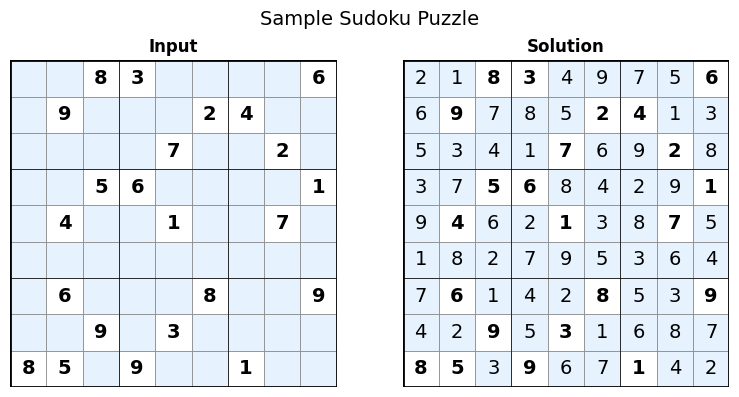


✅ Part 1 Complete! Dataset ready for training.


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 10: Test Dataset Loading
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("🧪 Testing Dataset Loading")
print("="*70)

# Create a small test dataset
test_dataset = PuzzleDataset(
    dataset_paths=[OUTPUT_DIR],
    global_batch_size=32,
    seed=42,
    test_set_mode=True,
    epochs_per_iter=1,
    rank=0,
    num_replicas=1,
    split="test"
)

print(f"\n📊 Dataset metadata:")
print(f"  Sequence length: {test_dataset.metadata.seq_len}")
print(f"  Vocabulary size: {test_dataset.metadata.vocab_size}")
print(f"  Total puzzles: {test_dataset.metadata.total_puzzles}")

# Get one batch
dataloader = DataLoader(test_dataset, batch_size=None)
set_name, batch, batch_size = next(iter(dataloader))

print(f"\n📦 Sample batch:")
print(f"  Set name: {set_name}")
print(f"  Batch size: {batch_size}")
print(f"  Input shape: {batch['inputs'].shape}")
print(f"  Labels shape: {batch['labels'].shape}")
print(f"  Input range: [{batch['inputs'].min()}, {batch['inputs'].max()}]")
print(f"  Labels range: [{batch['labels'].min()}, {batch['labels'].max()}]")

# Visualize first example
print("\n🎨 Visualizing first example...")
first_input = batch['inputs'][0].numpy().reshape(9, 9)
first_label = batch['labels'][0].numpy().reshape(9, 9)
visualize_sudoku(first_input, first_label, title="Sample Sudoku Puzzle")

print("\n" + "="*70)
print("✅ Part 1 Complete! Dataset ready for training.")
print("="*70)

# 📦 Part 2: Original TinyRecursiveModels Implementation

This section implements the original TinyRecursiveModels (TRM) architecture from the paper "Less is More: Recursive Reasoning with Tiny Networks".

## Key Components:
1. **Basic Layers**: `CastedLinear`, `CastedEmbedding`, `RotaryEmbedding`
2. **Attention & FFN**: `Attention`, `SwiGLU`, `rms_norm`
3. **Sparse Embedding**: `CastedSparseEmbedding` for puzzle-specific embeddings
4. **TRM Model**: Hierarchical recursive reasoning with ACT (Adaptive Computation Time)
5. **Loss Functions**: `ACTLossHead` with stablemax cross-entropy

## Cell 11: Original Layers

Basic building blocks for the TRM model:
- `CastedLinear`: Linear layer with automatic dtype casting
- `CastedEmbedding`: Embedding layer with dtype casting
- `RotaryEmbedding`: Rotary Position Embedding (RoPE)
- `Attention`: Multi-head attention with RoPE support
- `SwiGLU`: SwiGLU FFN (as used in LLaMA)
- `rms_norm`: Root Mean Square Layer Normalization

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 11: Original Layers (CastedLinear, CastedEmbedding, Attention, etc.)
# ═══════════════════════════════════════════════════════════════════════════════

# Type alias for RoPE cos/sin tensors
CosSin = Tuple[torch.Tensor, torch.Tensor]

def _find_multiple(a: int, b: int) -> int:
    """Find smallest multiple of b that is >= a (ceiling division * b)."""
    return (-(a // -b)) * b

# ============ RoPE Helpers ============
def rotate_half(x: torch.Tensor) -> torch.Tensor:
    """Rotates half the hidden dims of the input for RoPE."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(
    q: torch.Tensor,
    k: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Apply rotary position embeddings to query and key tensors.

    Args:
        q, k: [batch_size, seq_len, num_heads, head_dim]
        cos, sin: [seq_len, head_dim]
    """
    orig_dtype = q.dtype
    q = q.to(cos.dtype)
    k = k.to(cos.dtype)

    q_embed = (q * cos.unsqueeze(-2)) + (rotate_half(q) * sin.unsqueeze(-2))
    k_embed = (k * cos.unsqueeze(-2)) + (rotate_half(k) * sin.unsqueeze(-2))

    return q_embed.to(orig_dtype), k_embed.to(orig_dtype)

# ============ CastedLinear ============
class CastedLinear(nn.Module):
    """Linear layer with automatic dtype casting and truncated normal init."""

    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        # Truncated LeCun normal init: std = 1/sqrt(fan_in)
        self.weight = nn.Parameter(
            trunc_normal_init_(torch.empty((out_features, in_features)), std=1.0 / (in_features ** 0.5))
        )
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.zeros((out_features,)))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(
            input,
            self.weight.to(input.dtype),
            bias=self.bias.to(input.dtype) if self.bias is not None else None
        )

# ============ CastedEmbedding ============
class CastedEmbedding(nn.Module):
    """Embedding layer with dtype casting and truncated normal init."""

    def __init__(self, num_embeddings: int, embedding_dim: int, init_std: float, cast_to: torch.dtype):
        super().__init__()
        self.cast_to = cast_to
        self.embedding_weight = nn.Parameter(
            trunc_normal_init_(torch.empty((num_embeddings, embedding_dim)), std=init_std)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.embedding(input, self.embedding_weight.to(self.cast_to))

# ============ RotaryEmbedding ============
class RotaryEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE) as used in LLaMA."""

    def __init__(self, dim: int, max_position_embeddings: int, base: float = 10000.0, device=None):
        super().__init__()

        # Compute inverse frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32, device=device) / dim))
        t = torch.arange(max_position_embeddings, dtype=torch.float32, device=device)
        freqs = torch.outer(t, inv_freq)

        # Cache cos and sin
        emb = torch.cat((freqs, freqs), dim=-1)
        self.cos_cached = nn.Buffer(emb.cos(), persistent=False)
        self.sin_cached = nn.Buffer(emb.sin(), persistent=False)

    def forward(self) -> CosSin:
        return self.cos_cached, self.sin_cached

# ============ Attention ============
class Attention(nn.Module):
    """Multi-head attention with optional RoPE and causal masking."""

    def __init__(
        self,
        hidden_size: int,
        head_dim: int,
        num_heads: int,
        num_key_value_heads: int,
        causal: bool = False
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.head_dim = head_dim
        self.output_size = head_dim * num_heads
        self.num_heads = num_heads
        self.num_key_value_heads = num_key_value_heads
        self.causal = causal

        # Fused QKV projection
        self.qkv_proj = CastedLinear(
            self.hidden_size,
            (self.num_heads + 2 * self.num_key_value_heads) * self.head_dim,
            bias=False
        )
        self.o_proj = CastedLinear(self.output_size, self.hidden_size, bias=False)

    def forward(self, cos_sin: CosSin, hidden_states: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = hidden_states.shape

        # QKV projection
        qkv = self.qkv_proj(hidden_states)
        qkv = qkv.view(batch_size, seq_len, self.num_heads + 2 * self.num_key_value_heads, self.head_dim)

        query = qkv[:, :, :self.num_heads]
        key = qkv[:, :, self.num_heads: self.num_heads + self.num_key_value_heads]
        value = qkv[:, :, self.num_heads + self.num_key_value_heads:]

        # Apply RoPE
        if cos_sin is not None:
            cos, sin = cos_sin
            query, key = apply_rotary_pos_emb(query, key, cos, sin)

        # Scaled dot-product attention
        # Reshape for attention: [B, S, H, D] -> [B, H, S, D]
        query = einops.rearrange(query, 'B S H D -> B H S D')
        key = einops.rearrange(key, 'B S H D -> B H S D')
        value = einops.rearrange(value, 'B S H D -> B H S D')

        attn_output = F.scaled_dot_product_attention(
            query=query, key=key, value=value, is_causal=self.causal
        )

        # Reshape back: [B, H, S, D] -> [B, S, H*D]
        attn_output = einops.rearrange(attn_output, 'B H S D -> B S (H D)')

        return self.o_proj(attn_output)

# ============ SwiGLU FFN ============
class SwiGLU(nn.Module):
    """SwiGLU Feed-Forward Network as used in LLaMA."""

    def __init__(self, hidden_size: int, expansion: float):
        super().__init__()
        # Compute intermediate size (2/3 * expansion * hidden_size, rounded to multiple of 256)
        inter = _find_multiple(round(expansion * hidden_size * 2 / 3), 256)

        self.gate_up_proj = CastedLinear(hidden_size, inter * 2, bias=False)
        self.down_proj = CastedLinear(inter, hidden_size, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate, up = self.gate_up_proj(x).chunk(2, dim=-1)
        return self.down_proj(F.silu(gate) * up)

# ============ RMS Normalization ============
def rms_norm(hidden_states: torch.Tensor, variance_epsilon: float = 1e-5) -> torch.Tensor:
    """Root Mean Square Layer Normalization."""
    input_dtype = hidden_states.dtype
    hidden_states = hidden_states.to(torch.float32)

    variance = hidden_states.square().mean(-1, keepdim=True)
    hidden_states = hidden_states * torch.rsqrt(variance + variance_epsilon)

    return hidden_states.to(input_dtype)

# ============ LinearSwish (optional) ============
class LinearSwish(nn.Module):
    """Linear layer with SiLU activation."""

    def __init__(self, hidden_size: int, reverse: bool = False):
        super().__init__()
        self.linear = CastedLinear(hidden_size, hidden_size, bias=False)
        self.reverse = reverse

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.reverse:
            return F.silu(self.linear(x))
        else:
            return self.linear(F.silu(x))

print("="*70)
print("✅ Original Layers defined!")
print("="*70)
print("\n📋 Available layers:")
print("  - CastedLinear: Linear with dtype casting")
print("  - CastedEmbedding: Embedding with dtype casting")
print("  - RotaryEmbedding: RoPE positional encoding")
print("  - Attention: Multi-head attention with RoPE")
print("  - SwiGLU: SwiGLU FFN")
print("  - rms_norm: RMS normalization function")

✅ Original Layers defined!

📋 Available layers:
  - CastedLinear: Linear with dtype casting
  - CastedEmbedding: Embedding with dtype casting
  - RotaryEmbedding: RoPE positional encoding
  - Attention: Multi-head attention with RoPE
  - SwiGLU: SwiGLU FFN
  - rms_norm: RMS normalization function


## Cell 12: Original SparseEmbedding

Puzzle-specific embeddings that are:
- Efficiently updated using SignSGD (sparse gradient update)
- Cast to the forward dtype during forward pass
- Stored locally for gradient accumulation during training

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 12: Original SparseEmbedding
# ═══════════════════════════════════════════════════════════════════════════════

class CastedSparseEmbedding(nn.Module):
    """
    Sparse embedding for puzzle-specific parameters.

    During training:
    - Copies embeddings to local buffer for gradient computation
    - Uses SignSGD for efficient sparse updates

    During inference:
    - Directly indexes into the weight matrix
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        batch_size: int,
        init_std: float,
        cast_to: torch.dtype
    ):
        super().__init__()
        self.cast_to = cast_to

        # Main weights (persistent, no gradient)
        self.weights = nn.Buffer(
            trunc_normal_init_(torch.empty((num_embeddings, embedding_dim)), std=init_std),
            persistent=True
        )

        # Local weights for training (with gradient, not persistent)
        self.local_weights = nn.Buffer(
            torch.zeros(batch_size, embedding_dim, requires_grad=True),
            persistent=False
        )
        # Local IDs tracking which embeddings are in local_weights
        self.local_ids = nn.Buffer(
            torch.zeros(batch_size, dtype=torch.int32),
            persistent=False
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        if not self.training:
            # Inference: direct lookup
            return self.weights[inputs].to(self.cast_to)

        # Training: copy to local buffer for gradient
        with torch.no_grad():
            self.local_weights.copy_(self.weights[inputs])
            self.local_ids.copy_(inputs)

        # Retain gradient for non-leaf tensor
        self.local_weights.retain_grad()

        return self.local_weights.to(self.cast_to)


class CastedSparseEmbeddingSignSGD(torch.optim.Optimizer):
    """
    SignSGD optimizer for sparse embeddings.

    Adam ≈ SignSGD when gradients are very sparse, so this is more efficient.
    """

    def __init__(
        self,
        params,
        lr: float = 1e-3,
        weight_decay: float = 1e-2,
    ):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, weight_decay=weight_decay)

        # Manually set param_groups to bypass PyTorch's leaf tensor check
        # Buffers are not leaf tensors, but we handle them specially in step()
        if isinstance(params, torch.Tensor):
            params = [params]

        # Convert to list if needed
        params = list(params)

        # Create param_groups manually (bypassing super().__init__ validation)
        # We directly set param_groups without calling add_param_group to avoid validation
        if isinstance(params[0], dict):
            param_groups = params
        else:
            param_groups = [{'params': params}]

        # Initialize Optimizer base class attributes manually
        self.defaults = defaults
        import weakref
        self.state = weakref.WeakValueDictionary()
        self._hook_for_profile = None
        from collections import OrderedDict
        self._optimizer_step_pre_hooks = OrderedDict()
        self._optimizer_step_post_hooks = OrderedDict()

        # Set param_groups directly (merge defaults into each group)
        self.param_groups = []
        for param_group in param_groups:
            # Merge defaults with param_group
            merged_group = {**defaults, **param_group}
            self.param_groups.append(merged_group)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            # Find sparse embedding components
            local_weights_grad = None
            local_ids = None
            weights = None

            for p in group["params"]:
                if p.requires_grad:
                    # Use getattr to safely access grad without triggering warnings
                    local_weights_grad = getattr(p, 'grad', None)
                elif p.ndim == 1:
                    local_ids = p
                elif p.ndim == 2:
                    weights = p

            if local_weights_grad is None or local_ids is None or weights is None:
                continue

            # Unique IDs and aggregate gradients
            grad_ids, inv = local_ids.unique(return_inverse=True)
            N, D = local_weights_grad.shape

            grad = torch.zeros((grad_ids.shape[0], D), dtype=local_weights_grad.dtype, device=local_weights_grad.device)
            grad.scatter_add_(0, inv.unsqueeze(-1).expand(-1, D), local_weights_grad)

            # SignSGD with decoupled weight decay
            p = weights[grad_ids]
            p.mul_(1.0 - group["lr"] * group["weight_decay"])
            p.add_(torch.sign(grad), alpha=-group["lr"])

            # Write back
            weights[grad_ids] = p


print("="*70)
print("✅ Original SparseEmbedding defined!")
print("="*70)
print("\n📋 Available classes:")
print("  - CastedSparseEmbedding: Sparse embedding with efficient updates")
print("  - CastedSparseEmbeddingSignSGD: SignSGD optimizer for sparse embeddings")

✅ Original SparseEmbedding defined!

📋 Available classes:
  - CastedSparseEmbedding: Sparse embedding with efficient updates
  - CastedSparseEmbeddingSignSGD: SignSGD optimizer for sparse embeddings


## Cell 13: Original TRM Model

The TinyRecursiveReasoningModel with Adaptive Computation Time (ACT):

**Architecture:**
- **H-level**: High-level reasoning state (updated every H_cycles)
- **L-level**: Low-level reasoning state (updated every L_cycles within each H-cycle)
- **Input injection**: Token embeddings + puzzle embeddings injected at each L-step

**ACT (Adaptive Computation Time):**
- Model learns when to halt computation via Q-learning
- `q_halt_logits`: Confidence that current answer is correct
- `q_continue_logits`: Expected value of continuing computation
- Exploration during training: Random early halting with probability `halt_exploration_prob`

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 13: Original TRM Model (TRMConfig, TRMBlock, TRMInner, TRM)
# ═══════════════════════════════════════════════════════════════════════════════

# ============ Carry Dataclasses ============
@dataclass
class TRMInnerCarry:
    """Inner carry state for TRM reasoning."""
    z_H: torch.Tensor  # High-level state: [B, L+puzzle_emb_len, D]
    z_L: torch.Tensor  # Low-level state: [B, L+puzzle_emb_len, D]


@dataclass
class TRMCarry:
    """Full carry state including ACT status."""
    inner_carry: TRMInnerCarry
    steps: torch.Tensor         # Current step count: [B]
    halted: torch.Tensor        # Whether each sequence has halted: [B]
    current_data: Dict[str, torch.Tensor]  # Current batch data


# ============ TRM Configuration ============
class OriginalTRMConfig(BaseModel):
    """Configuration for the original TinyRecursiveReasoningModel."""

    # Data dimensions
    batch_size: int
    seq_len: int
    vocab_size: int
    num_puzzle_identifiers: int

    # Model dimensions
    hidden_size: int = 512
    expansion: float = 4.0
    num_heads: int = 8

    # Puzzle embeddings
    puzzle_emb_ndim: int = 512
    puzzle_emb_len: int = 16

    # Recursion structure
    H_cycles: int = 3           # High-level cycles
    L_cycles: int = 6           # Low-level cycles per H-cycle
    H_layers: int = 0           # Layers in H-block (ignored in original)
    L_layers: int = 2           # Layers in L-block

    # Position encoding
    pos_encodings: str = "rope"  # "rope", "learned", or "none"
    rope_theta: float = 10000.0

    # Normalization
    rms_norm_eps: float = 1e-5

    # ACT (Adaptive Computation Time)
    halt_max_steps: int = 16
    halt_exploration_prob: float = 0.1

    # Dtype
    forward_dtype: str = "bfloat16"

    # Additional options
    mlp_t: bool = False          # Use MLP instead of transformer on L
    no_ACT_continue: bool = True # Only use halt sigmoid, no continue loss


# ============ TRM Block ============
class TRMBlock(nn.Module):
    """Single transformer block for TRM."""

    def __init__(self, config: OriginalTRMConfig):
        super().__init__()
        self.config = config

        if config.mlp_t:
            # MLP over sequence dimension instead of attention
            self.puzzle_emb_len = -(config.puzzle_emb_ndim // -config.hidden_size) if config.puzzle_emb_len == 0 else config.puzzle_emb_len
            self.mlp_t = SwiGLU(
                hidden_size=config.seq_len + self.puzzle_emb_len, # L
                expansion=config.expansion,
            )
        else:
            # Standard self-attention
            self.self_attn = Attention(
                hidden_size=config.hidden_size,
                head_dim=config.hidden_size // config.num_heads,
                num_heads=config.num_heads,
                num_key_value_heads=config.num_heads,
                causal=False
            )

        # FFN
        self.mlp = SwiGLU(
            hidden_size=config.hidden_size,
            expansion=config.expansion,
        )
        self.norm_eps = config.rms_norm_eps

    def forward(self, cos_sin: CosSin, hidden_states: torch.Tensor) -> torch.Tensor:
        # B, L, D = hidden_states.shape
        # Post Norm
        if self.config.mlp_t:
            hidden_states = hidden_states.transpose(1,2)
            out = self.mlp_t(hidden_states)
            hidden_states = rms_norm(hidden_states + out, variance_epsilon=self.norm_eps)
            hidden_states = hidden_states.transpose(1,2)
        else:
            # Self Attention
            hidden_states = rms_norm(hidden_states + self.self_attn(cos_sin=cos_sin, hidden_states=hidden_states), variance_epsilon=self.norm_eps)
        # Fully Connected
        out = self.mlp(hidden_states)
        hidden_states = rms_norm(hidden_states + out, variance_epsilon=self.norm_eps)
        return hidden_states


# ============ TRM Reasoning Module ============
class TRMReasoningModule(nn.Module):
    """Stack of TRM blocks with input injection."""

    def __init__(self, layers: List[TRMBlock]):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_injection: torch.Tensor,
        **kwargs
    ) -> torch.Tensor:
        hidden_states = hidden_states + input_injection
        for layer in self.layers:
            hidden_states = layer(hidden_states=hidden_states, **kwargs)
        return hidden_states


# ============ TRM Inner Model ============
class TRMInner(nn.Module):
    """Inner TRM model (without ACT wrapper)."""

    def __init__(self, config: OriginalTRMConfig):
        super().__init__()
        self.config = config
        self.forward_dtype = getattr(torch, config.forward_dtype)

        # Embedding scale
        self.embed_scale = math.sqrt(config.hidden_size)
        embed_init_std = 1.0 / self.embed_scale

        # Token embeddings
        self.embed_tokens = CastedEmbedding(
            config.vocab_size,
            config.hidden_size,
            init_std=embed_init_std,
            cast_to=self.forward_dtype
        )

        # Output heads
        self.lm_head = CastedLinear(config.hidden_size, config.vocab_size, bias=False)
        self.q_head = CastedLinear(config.hidden_size, 2, bias=True)  # [halt, continue]

        # Puzzle embeddings
        self.puzzle_emb_len = -(config.puzzle_emb_ndim // -config.hidden_size) if config.puzzle_emb_len == 0 else config.puzzle_emb_len  # ceil div
        if config.puzzle_emb_ndim > 0:
            self.puzzle_emb = CastedSparseEmbedding(
                config.num_puzzle_identifiers,
                config.puzzle_emb_ndim,
                batch_size=config.batch_size,
                init_std=0,  # Zero init puzzle embeddings
                cast_to=self.forward_dtype
            )

        # Position encodings
        if config.pos_encodings == "rope":
            self.rotary_emb = RotaryEmbedding(
                dim=config.hidden_size // config.num_heads,
                max_position_embeddings=config.seq_len + self.puzzle_emb_len,
                base=config.rope_theta
            )
        elif config.pos_encodings == "learned":
            self.embed_pos = CastedEmbedding(
                config.seq_len + self.puzzle_emb_len,
                config.hidden_size,
                init_std=embed_init_std,
                cast_to=self.forward_dtype
            )

        # Reasoning layers (L-level)
        self.L_level = TRMReasoningModule(
            layers=[TRMBlock(config) for _ in range(config.L_layers)]
        )

        # Initial states for H and L
        self.H_init = nn.Buffer(
            trunc_normal_init_(torch.empty(config.hidden_size, dtype=self.forward_dtype), std=1),
            persistent=True
        )
        self.L_init = nn.Buffer(
            trunc_normal_init_(torch.empty(config.hidden_size, dtype=self.forward_dtype), std=1),
            persistent=True
        )

        # Initialize Q-head to near-zero for faster learning
        with torch.no_grad():
            self.q_head.weight.zero_()
            self.q_head.bias.fill_(-5)

    def _input_embeddings(self, input: torch.Tensor, puzzle_identifiers: torch.Tensor) -> torch.Tensor:
        """Compute input embeddings including puzzle embeddings and position encodings."""
        # Token embedding
        embedding = self.embed_tokens(input.to(torch.int32))

        # Puzzle embeddings
        if self.config.puzzle_emb_ndim > 0:
            puzzle_embedding = self.puzzle_emb(puzzle_identifiers)

            # Pad if needed
            pad_count = self.puzzle_emb_len * self.config.hidden_size - puzzle_embedding.shape[-1]
            if pad_count > 0:
                puzzle_embedding = F.pad(puzzle_embedding, (0, pad_count))

            # Reshape and prepend to embedding
            embedding = torch.cat(
                (puzzle_embedding.view(-1, self.puzzle_emb_len, self.config.hidden_size), embedding),
                dim=-2
            )

        # Learned position embeddings
        if self.config.pos_encodings == "learned":
            embedding = 0.707106781 * (embedding + self.embed_pos.embedding_weight.to(self.forward_dtype))

        # Scale
        return self.embed_scale * embedding

    def empty_carry(self, batch_size: int):
        """Create empty carry state (with device fix for CUDA compatibility)."""
        # Get device from model parameters if available
        device = next(self.parameters()).device if list(self.parameters()) else None

        return TRMInnerCarry(
            z_H=torch.empty(batch_size, self.config.seq_len + self.puzzle_emb_len, self.config.hidden_size, dtype=self.forward_dtype, device=device),
            z_L=torch.empty(batch_size, self.config.seq_len + self.puzzle_emb_len, self.config.hidden_size, dtype=self.forward_dtype, device=device),
        )

    def reset_carry(self, reset_flag: torch.Tensor, carry: TRMInnerCarry):
        """Reset carry state for halted sequences (with device fix for CUDA compatibility)."""
        # Ensure buffers are on the same device as carry (fix for CUDA)
        device = carry.z_H.device
        H_init = self.H_init.to(device)
        L_init = self.L_init.to(device)

        return TRMInnerCarry(
            z_H=torch.where(reset_flag.view(-1, 1, 1), H_init, carry.z_H),
            z_L=torch.where(reset_flag.view(-1, 1, 1), L_init, carry.z_L),
        )

    def forward(
        self,
        carry: TRMInnerCarry,
        batch: Dict[str, torch.Tensor]
    ) -> Tuple[TRMInnerCarry, torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Forward pass through TRM."""

        # Get RoPE embeddings
        cos_sin = self.rotary_emb() if hasattr(self, "rotary_emb") else None
        seq_info = dict(cos_sin=cos_sin)

        # Input encoding
        input_embeddings = self._input_embeddings(batch["inputs"], batch["puzzle_identifiers"])

        # Recursive reasoning
        z_H, z_L = carry.z_H, carry.z_L

        # H_cycles-1 iterations without gradient (for efficiency)
        with torch.no_grad():
            for _H_step in range(self.config.H_cycles - 1):
                for _L_step in range(self.config.L_cycles):
                    z_L = self.L_level(z_L, z_H + input_embeddings, **seq_info)
                z_H = self.L_level(z_H, z_L, **seq_info)

        # Last H-cycle with gradient
        for _L_step in range(self.config.L_cycles):
            z_L = self.L_level(z_L, z_H + input_embeddings, **seq_info)
        z_H = self.L_level(z_H, z_L, **seq_info)

        # LM Outputs
        new_carry = TRMInnerCarry(z_H=z_H.detach(), z_L=z_L.detach())  # New carry no grad
        output = self.lm_head(z_H)[:, self.puzzle_emb_len:]
        q_logits = self.q_head(z_H[:, 0]).to(torch.float32) # Q-head; uses the first puzzle_emb position
        return new_carry, output, (q_logits[..., 0], q_logits[..., 1])


# ============ TRM with ACT Wrapper ============
class OriginalTRM(nn.Module):
    """Original TinyRecursiveReasoningModel with Adaptive Computation Time (ACT)."""

    def __init__(self, config_dict: dict):
        super().__init__()
        self.config = OriginalTRMConfig(**config_dict)
        self.inner = TRMInner(self.config)

    @property
    def puzzle_emb(self):
        return self.inner.puzzle_emb

    def initial_carry(self, batch: Dict[str, torch.Tensor]):
        """Initialize carry state for a batch (with device fix for CUDA compatibility)."""
        batch_size = batch["inputs"].shape[0]
        device = batch["inputs"].device

        # Move model to device if needed (ensures buffers are on correct device)
        if next(self.inner.parameters()).device != device:
            self.inner = self.inner.to(device)

        return TRMCarry(
            inner_carry=self.inner.empty_carry(batch_size),
            steps=torch.zeros((batch_size,), dtype=torch.int32, device=device),
            halted=torch.ones((batch_size,), dtype=torch.bool, device=device),  # Start halted to trigger reset
            current_data={k: torch.empty_like(v) for k, v in batch.items()}
        )

    def forward(
        self,
        carry: TRMCarry,
        batch: Dict[str, torch.Tensor]
    ) -> Tuple[TRMCarry, Dict[str, torch.Tensor]]:
        """Forward pass with ACT."""

        # Update data, carry (removing halted sequences)
        new_inner_carry = self.inner.reset_carry(carry.halted, carry.inner_carry)

        new_steps = torch.where(carry.halted, 0, carry.steps)

        new_current_data = {k: torch.where(carry.halted.view((-1, ) + (1, ) * (batch[k].ndim - 1)), batch[k], v) for k, v in carry.current_data.items()}

        # Forward inner model
        new_inner_carry, logits, (q_halt_logits, q_continue_logits) = self.inner(new_inner_carry, new_current_data)

        outputs = {
            "logits": logits,
            "q_halt_logits": q_halt_logits,
            "q_continue_logits": q_continue_logits
        }

        with torch.no_grad():
            # Step
            new_steps = new_steps + 1
            is_last_step = new_steps >= self.config.halt_max_steps

            halted = is_last_step

            # if training, and ACT is enabled
            if self.training and (self.config.halt_max_steps > 1):

                # Halt signal
                # NOTE: During evaluation, always use max steps, this is to guarantee the same halting steps inside a batch for batching purposes

                if self.config.no_ACT_continue:
                    halted = halted | (q_halt_logits > 0)
                else:
                    halted = halted | (q_halt_logits > q_continue_logits)

                # Exploration
                min_halt_steps = (torch.rand_like(q_halt_logits) < self.config.halt_exploration_prob) * torch.randint_like(new_steps, low=2, high=self.config.halt_max_steps + 1)
                halted = halted & (new_steps >= min_halt_steps)

                if not self.config.no_ACT_continue:
                    # Compute target Q
                    # NOTE: No replay buffer and target networks for computing target Q-value.
                    # As batch_size is large, there're many parallel envs.
                    # Similar concept as PQN https://arxiv.org/abs/2407.04811
                    _, _, (next_q_halt_logits, next_q_continue_logits) = self.inner(new_inner_carry, new_current_data)
                    outputs["target_q_continue"] = torch.sigmoid(torch.where(is_last_step, next_q_halt_logits, torch.maximum(next_q_halt_logits, next_q_continue_logits)))

        return TRMCarry(new_inner_carry, new_steps, halted, new_current_data), outputs


print("="*70)
print("✅ Original TRM Model defined!")
print("="*70)
print("\n📋 Model components:")
print("  - OriginalTRMConfig: Model configuration")
print("  - TRMBlock: Single transformer block")
print("  - TRMReasoningModule: Stack of TRM blocks")
print("  - TRMInner: Core reasoning model")
print("  - OriginalTRM: Full model with ACT wrapper")

✅ Original TRM Model defined!

📋 Model components:
  - OriginalTRMConfig: Model configuration
  - TRMBlock: Single transformer block
  - TRMReasoningModule: Stack of TRM blocks
  - TRMInner: Core reasoning model
  - OriginalTRM: Full model with ACT wrapper


## Cell 14: Original Loss Functions

Loss functions for training TRM:
- **Stablemax Cross-Entropy**: More stable alternative to softmax for numerical stability
- **ACTLossHead**: Combines LM loss with Q-learning losses for ACT

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 14: Original Loss Functions
# ═══════════════════════════════════════════════════════════════════════════════

# ============ Stablemax Functions ============
def s(x: torch.Tensor, epsilon: float = 1e-30) -> torch.Tensor:
    """Stablemax helper function."""
    return torch.where(
        x < 0,
        1 / (1 - x + epsilon),
        x + 1
    )

def log_stablemax(x: torch.Tensor, dim: int = -1) -> torch.Tensor:
    """Log-stablemax: more stable than log-softmax for certain distributions."""
    s_x = s(x)
    return torch.log(s_x / torch.sum(s_x, dim=dim, keepdim=True))

def stablemax_cross_entropy(
    logits: torch.Tensor,
    labels: torch.Tensor,
    ignore_index: int = IGNORE_LABEL_ID,
    valid_mask: torch.Tensor = None
) -> torch.Tensor:
    """
    Cross-entropy loss using stablemax instead of softmax.

    More numerically stable for certain distributions.
    """
    logprobs = log_stablemax(logits.to(torch.float64), dim=-1)

    if valid_mask is None:
        valid_mask = (labels != ignore_index)

    transformed_labels = torch.where(valid_mask, labels, 0)
    prediction_logprobs = torch.gather(
        logprobs,
        index=transformed_labels.to(torch.long).unsqueeze(-1),
        dim=-1
    ).squeeze(-1)

    return -torch.where(valid_mask, prediction_logprobs, 0)

def softmax_cross_entropy(
    logits: torch.Tensor,
    labels: torch.Tensor,
    ignore_index: int = IGNORE_LABEL_ID,
    valid_mask: torch.Tensor = None  # unused, for API compatibility
) -> torch.Tensor:
    """Standard softmax cross-entropy loss."""
    return F.cross_entropy(
        logits.to(torch.float32).view(-1, logits.shape[-1]),
        labels.to(torch.long).view(-1),
        ignore_index=ignore_index,
        reduction="none"
    ).view(labels.shape)


# ============ ACT Loss Head ============
class ACTLossHead(nn.Module):
    """
    Loss head for TRM with Adaptive Computation Time.

    Combines:
    1. LM loss (stablemax or softmax cross-entropy)
    2. Q-halt loss (BCE for halting decision)
    3. Q-continue loss (optional, for Q-learning)
    """

    def __init__(self, model: nn.Module, loss_type: str = "stablemax_cross_entropy"):
        super().__init__()
        self.model = model

        # Get loss function by name
        loss_functions = {
            "stablemax_cross_entropy": stablemax_cross_entropy,
            "softmax_cross_entropy": softmax_cross_entropy
        }
        self.loss_fn = loss_functions[loss_type]

    def initial_carry(self, *args, **kwargs):
        return self.model.initial_carry(*args, **kwargs)

    def forward(
        self,
        return_keys: Sequence[str] = (),
        **model_kwargs,
    ) -> Tuple[Any, torch.Tensor, Dict[str, torch.Tensor], Optional[Dict[str, torch.Tensor]], torch.Tensor]:
        """
        Forward pass computing loss and metrics.

        Returns:
            - new_carry: Updated carry state
            - loss: Total loss (LM + Q-halt + Q-continue)
            - metrics: Dictionary of metrics (accuracy, loss components, etc.)
            - detached_outputs: Requested output tensors (detached)
            - all_halted: Whether all sequences have halted
        """
        # Forward through model
        new_carry, outputs = self.model(**model_kwargs)
        labels = new_carry.current_data["labels"]

        with torch.no_grad():
            # Predictions
            outputs["preds"] = torch.argmax(outputs["logits"], dim=-1)

            # Compute correctness
            mask = (labels != IGNORE_LABEL_ID)
            loss_counts = mask.sum(-1)
            loss_divisor = loss_counts.clamp_min(1).unsqueeze(-1)

            is_correct = mask & (torch.argmax(outputs["logits"], dim=-1) == labels)
            seq_is_correct = is_correct.sum(-1) == loss_counts

            # Metrics (only for halted sequences)
            valid_metrics = new_carry.halted & (loss_counts > 0)
            metrics = {
                "count": valid_metrics.sum(),
                "accuracy": torch.where(valid_metrics, (is_correct.to(torch.float32) / loss_divisor).sum(-1), 0).sum(),
                "exact_accuracy": (valid_metrics & seq_is_correct).sum(),
                "q_halt_accuracy": (valid_metrics & ((outputs["q_halt_logits"] >= 0) == seq_is_correct)).sum(),
                "steps": torch.where(valid_metrics, new_carry.steps, 0).sum(),
            }

        # Losses
        lm_loss = (self.loss_fn(outputs["logits"], labels, ignore_index=IGNORE_LABEL_ID, valid_mask=mask) / loss_divisor).sum()
        q_halt_loss = F.binary_cross_entropy_with_logits(
            outputs["q_halt_logits"],
            seq_is_correct.to(outputs["q_halt_logits"].dtype),
            reduction="sum"
        )

        metrics.update({
            "lm_loss": lm_loss.detach(),
            "q_halt_loss": q_halt_loss.detach(),
        })

        # Q-continue loss (optional)
        q_continue_loss = 0
        if "target_q_continue" in outputs:
            q_continue_loss = F.binary_cross_entropy_with_logits(
                outputs["q_continue_logits"],
                outputs["target_q_continue"],
                reduction="sum"
            )
            metrics["q_continue_loss"] = q_continue_loss.detach()

        # Total loss
        total_loss = lm_loss + 0.5 * (q_halt_loss + q_continue_loss)

        # Detached outputs
        detached_outputs = {k: outputs[k].detach() for k in return_keys if k in outputs}

        return new_carry, total_loss, metrics, detached_outputs, new_carry.halted.all()


print("="*70)
print("✅ Original Loss Functions defined!")
print("="*70)
print("\n📋 Available functions:")
print("  - stablemax_cross_entropy: Stablemax-based cross-entropy")
print("  - softmax_cross_entropy: Standard cross-entropy")
print("  - ACTLossHead: Combined loss for TRM with ACT")

✅ Original Loss Functions defined!

📋 Available functions:
  - stablemax_cross_entropy: Stablemax-based cross-entropy
  - softmax_cross_entropy: Standard cross-entropy
  - ACTLossHead: Combined loss for TRM with ACT


## Cell 15: Test Original TRM Model

Verify that the original TRM model works correctly by:
1. Creating a model instance with Sudoku configuration
2. Running a forward pass with sample data
3. Checking output shapes and loss computation

In [15]:
# # ═══════════════════════════════════════════════════════════════════════════════
# # Cell 15: Test Original TRM Model
# # ═══════════════════════════════════════════════════════════════════════════════

# print("="*70)
# print("🧪 Testing Original TRM Model")
# print("="*70)

# # ============ Model Configuration for Sudoku ============
# BATCH_SIZE = 32
# SEQ_LEN = 81  # 9x9 Sudoku

# original_trm_config = {
#     # Data dimensions
#     "batch_size": BATCH_SIZE,
#     "seq_len": SEQ_LEN,
#     "vocab_size": train_metadata.vocab_size,  # 11 for Sudoku (0-9 + pad)
#     "num_puzzle_identifiers": train_metadata.num_puzzle_identifiers,

#     # Model dimensions
#     "hidden_size": 512,
#     "expansion": 4.0,
#     "num_heads": 8,

#     # Puzzle embeddings
#     "puzzle_emb_ndim": 512,
#     "puzzle_emb_len": 16,

#     # Recursion structure
#     "H_cycles": 3,
#     "L_cycles": 6,
#     "H_layers": 0,
#     "L_layers": 2,

#     # Position encoding
#     "pos_encodings": "rope",
#     "rope_theta": 10000.0,

#     # ACT
#     "halt_max_steps": 16,
#     "halt_exploration_prob": 0.1,

#     # Dtype
#     "forward_dtype": "bfloat16",

#     # Options
#     "mlp_t": False,
#     "no_ACT_continue": True,
# }

# print("\n📋 Model Configuration:")
# for k, v in original_trm_config.items():
#     print(f"  {k}: {v}")

# # ============ Create Model ============
# print("\n🔧 Creating Original TRM model...")
# original_model = OriginalTRM(original_trm_config)
# original_model = original_model.to(DEVICE)

# # Count parameters
# total_params = sum(p.numel() for p in original_model.parameters())
# trainable_params = sum(p.numel() for p in original_model.parameters() if p.requires_grad)
# print(f"  Total parameters: {total_params:,}")
# print(f"  Trainable parameters: {trainable_params:,}")

# # ============ Create Loss Head ============
# print("\n🎯 Creating ACTLossHead...")
# original_loss_head = ACTLossHead(original_model, loss_type="stablemax_cross_entropy")
# original_loss_head = original_loss_head.to(DEVICE)

# # ============ Test Forward Pass ============
# print("\n🚀 Running test forward pass...")

# # Create test batch
# test_train_dataset = PuzzleDataset(
#     dataset_paths=[OUTPUT_DIR],
#     global_batch_size=BATCH_SIZE,
#     seed=42,
#     test_set_mode=False,
#     epochs_per_iter=1,
#     rank=0,
#     num_replicas=1,
#     split="train"
# )

# test_dataloader = DataLoader(test_train_dataset, batch_size=None)
# _, test_batch, _ = next(iter(test_dataloader))

# # Move to device
# test_batch = {k: v.to(DEVICE) for k, v in test_batch.items()}

# print(f"  Input shape: {test_batch['inputs'].shape}")
# print(f"  Labels shape: {test_batch['labels'].shape}")

# # Initialize carry
# original_model.train()
# carry = original_loss_head.initial_carry(batch=test_batch)

# # Forward pass
# new_carry, loss, metrics, outputs, all_halted = original_loss_head(
#     return_keys=["logits", "preds"],
#     carry=carry,
#     batch=test_batch
# )

# print(f"\n📊 Forward pass results:")
# print(f"  Loss: {loss.item():.4f}")
# print(f"  LM Loss: {metrics['lm_loss'].item():.4f}")
# print(f"  Q-Halt Loss: {metrics['q_halt_loss'].item():.4f}")
# print(f"  Accuracy: {metrics['accuracy'].item() / max(metrics['count'].item(), 1):.4f}")
# print(f"  Exact Accuracy: {metrics['exact_accuracy'].item() / max(metrics['count'].item(), 1):.4f}")
# print(f"  All Halted: {all_halted}")

# # ============ Test ACT Loop ============
# print("\n🔄 Testing ACT loop (multiple steps)...")
# carry = original_loss_head.initial_carry(batch=test_batch)

# step = 0
# while not all_halted and step < 20:  # Max 20 steps for safety
#     new_carry, loss, metrics, outputs, all_halted = original_loss_head(
#         return_keys=[],
#         carry=carry,
#         batch=test_batch
#     )
#     carry = new_carry
#     step += 1

#     halted_count = carry.halted.sum().item()
#     print(f"  Step {step}: Loss={loss.item():.4f}, Halted={halted_count}/{BATCH_SIZE}, "
#           f"Exact Acc={metrics['exact_accuracy'].item() / max(metrics['count'].item(), 1):.4f}")

# print(f"\n✅ ACT completed in {step} steps")

# print("\n" + "="*70)
# print("✅ Part 2 Complete! Original TRM Model is working.")
# print("="*70)

# 📦 Part 3: Training & Evaluation Framework

This section implements the training and evaluation framework for the TRM model.

## Components:
1. **TRMTrainer**: Trainer class for the original TRM model
2. **evaluate()**: Evaluation function with metrics logging
3. **train_epoch()**: Single epoch training with W&B logging
4. **Learning rate scheduler**: Cosine annealing with warmup

## Cell 22: Learning Rate Scheduler

Cosine annealing with linear warmup - standard for transformer training.

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 22: Learning Rate Scheduler
# ═══════════════════════════════════════════════════════════════════════════════

def get_lr_scheduler(optimizer, warmup_steps: int, total_steps: int, min_lr_ratio: float = 0.1):
    """
    Create a learning rate scheduler with linear warmup and cosine annealing.

    Args:
        optimizer: PyTorch optimizer
        warmup_steps: Number of warmup steps
        total_steps: Total training steps
        min_lr_ratio: Minimum LR as ratio of initial LR

    Returns:
        LambdaLR scheduler
    """
    def lr_lambda(current_step: int) -> float:
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        else:
            # Cosine annealing
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(min_lr_ratio, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def get_optimizer(model, lr: float, weight_decay: float, betas: Tuple[float, float] = (0.9, 0.95)):
    """
    Create AdamW optimizer with parameter groups.

    Separates:
    - Main parameters (with weight decay)
    - Bias and LayerNorm parameters (no weight decay)
    - LoRA parameters (separate group)

    Filters out:
    - Non-leaf tensors (which can't be optimized)
    - Buffers (even if requires_grad=True, they're handled separately by SignSGD)
    - Non nn.Parameter objects (extra safety)
    """
    # Get all buffer data_ptrs for identity comparison
    buffer_data_ptrs = {buf.data_ptr() for _, buf in model.named_buffers()}

    # Separate parameters
    decay_params = []
    no_decay_params = []
    lora_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        # Skip if this tensor is actually a buffer (check by data_ptr)
        if param.data_ptr() in buffer_data_ptrs:
            print(f"  ⚠️ Skipping buffer masquerading as parameter: {name}")
            continue

        # Skip non-leaf tensors (views, computed tensors, etc.)
        if not param.is_leaf:
            print(f"  ⚠️ Skipping non-leaf parameter: {name}")
            continue

        # Skip if not actually an nn.Parameter (extra safety)
        if not isinstance(param, nn.Parameter):
            print(f"  ⚠️ Skipping non-Parameter tensor: {name}")
            continue

        if 'lora' in name.lower():
            lora_params.append(param)
        elif 'bias' in name or 'norm' in name.lower() or 'ln' in name.lower():
            no_decay_params.append(param)
        else:
            decay_params.append(param)

    # Validate all parameters are leaf tensors before creating optimizer
    all_params = decay_params + no_decay_params + lora_params
    for param in all_params:
        if not param.is_leaf:
            raise ValueError(
                f"Found non-leaf tensor in optimizer parameters. "
                f"This usually means a parameter is a view or computed tensor. "
                f"Parameter shape: {param.shape}, requires_grad: {param.requires_grad}"
            )

    param_groups = []
    if decay_params:
        param_groups.append({'params': decay_params, 'weight_decay': weight_decay})
    if no_decay_params:
        param_groups.append({'params': no_decay_params, 'weight_decay': 0.0})
    if lora_params:
        param_groups.append({'params': lora_params, 'weight_decay': 0.0, 'lr': lr})  # LoRA often uses same LR

    try:
        optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=betas)
    except RuntimeError as e:
        if "non-leaf" in str(e).lower():
            # Print which parameters are problematic
            print("❌ Error creating optimizer. Checking parameters...")
            for name, param in model.named_parameters():
                if param.requires_grad and not param.is_leaf:
                    print(f"  Non-leaf parameter: {name}, shape: {param.shape}, is_leaf: {param.is_leaf}")
            raise RuntimeError(f"Optimizer creation failed: {e}")
        raise

    return optimizer


print("="*70)
print("✅ Learning Rate Scheduler and Optimizer defined!")
print("="*70)

✅ Learning Rate Scheduler and Optimizer defined!


## Cell 23: TRMTrainer Class

Trainer class for the TRM model.

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 23: TRMTrainer Class
# ═══════════════════════════════════════════════════════════════════════════════

@dataclass
class TrainerConfig:
    """Configuration for TRMTrainer."""
    # Training
    lr: float = 1e-4
    weight_decay: float = 0.1
    warmup_steps: int = 500
    max_steps: int = 10000
    eval_interval: int = 500
    log_interval: int = 50

    # Batch
    gradient_accumulation_steps: int = 1
    max_grad_norm: float = 1.0

    # EMA
    use_ema: bool = False
    ema_decay: float = 0.999

    # Sparse embedding
    puzzle_emb_lr: float = 1e-2
    puzzle_emb_weight_decay: float = 0.1

    # W&B
    project_name: str = "TRM-Comparison"
    run_name: Optional[str] = None

    # Save
    save_dir: str = "checkpoints"
    save_best: bool = True


class TRMTrainer:
    """
    Unified trainer for TinyRecursiveModels.

    Works with both Original and Optimized TRM models.
    """

    def __init__(
        self,
        model: nn.Module,
        loss_head: nn.Module,
        train_dataloader: DataLoader,
        eval_dataloader: DataLoader,
        config: TrainerConfig,
        device: torch.device,

    ):
        self.model = model
        self.loss_head = loss_head
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.config = config
        self.device = device


        # Optimizer
        self.optimizer = get_optimizer(
            model,
            lr=config.lr,
            weight_decay=config.weight_decay
        )

        # Scheduler
        self.scheduler = get_lr_scheduler(
            self.optimizer,
            warmup_steps=config.warmup_steps,
            total_steps=config.max_steps,
            min_lr_ratio=0.1
        )

        # Sparse embedding optimizer (if applicable)
        # NOTE: Use puzzle_emb.buffers() as in original pretrain.py
        self.sparse_emb_optimizer = None
        if hasattr(model, 'puzzle_emb'):
            puzzle_emb = model.puzzle_emb
            if hasattr(puzzle_emb, 'weights'):
                # Create sparse embedding optimizer using buffers() method
                # This matches the original implementation in pretrain.py
                sparse_buffers = list(puzzle_emb.buffers())
                self.sparse_emb_optimizer = CastedSparseEmbeddingSignSGD(
                    sparse_buffers,
                    lr=config.puzzle_emb_lr,
                    weight_decay=config.puzzle_emb_weight_decay
                )

        # EMA
        self.ema = None
        if config.use_ema:
            self.ema = EMAHelper(mu=config.ema_decay)
            self.ema.register(model)

        # State
        self.global_step = 0
        self.best_eval_accuracy = 0.0

        # Metrics accumulator
        self.train_metrics = {}

    def train_step(self, batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
        """Execute a single training step."""
        self.model.train()

        # Move batch to device
        batch = {k: v.to(self.device) for k, v in batch.items()}

        # Initialize carry
        carry = self.loss_head.initial_carry(batch=batch)

        # ACT loop
        total_loss = 0.0
        accumulated_metrics = {}
        step_count = 0
        all_halted = False

        while not all_halted and step_count < 50:  # Safety limit
            new_carry, loss, metrics, outputs, all_halted = self.loss_head(
                return_keys=[],
                carry=carry,
                batch=batch
            )
            carry = new_carry
            total_loss = total_loss + loss
            step_count += 1

            # Accumulate metrics
            for k, v in metrics.items():
                if k not in accumulated_metrics:
                    accumulated_metrics[k] = 0.0
                accumulated_metrics[k] += v.item() if torch.is_tensor(v) else v

        # Average loss over ACT steps
        avg_loss = total_loss / max(step_count, 1)

        # Backward
        avg_loss.backward()

        # Gradient clipping
        if self.config.max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)

        # Optimizer step
        self.optimizer.step()
        self.scheduler.step()
        self.optimizer.zero_grad()

        # Sparse embedding update
        if self.sparse_emb_optimizer is not None:
            self.sparse_emb_optimizer.step()
            self.sparse_emb_optimizer.zero_grad()

        # EMA update
        if self.ema is not None:
            self.ema.update(self.model)

        # Compute metrics
        count = accumulated_metrics.get('count', 1)
        result_metrics = {
            'loss': avg_loss.item(),
            'lm_loss': accumulated_metrics.get('lm_loss', 0) / max(count, 1),
            'q_halt_loss': accumulated_metrics.get('q_halt_loss', 0) / max(count, 1),
            'accuracy': accumulated_metrics.get('accuracy', 0) / max(count, 1),
            'exact_accuracy': accumulated_metrics.get('exact_accuracy', 0) / max(count, 1),
            'steps': accumulated_metrics.get('steps', 0) / max(count, 1),
            'lr': self.scheduler.get_last_lr()[0],
        }

        return result_metrics

    @torch.no_grad()
    def evaluate(self, max_batches: int = 50) -> Dict[str, float]:
        """Evaluate the model on the evaluation dataset."""
        self.model.eval()

        # Use EMA model if available
        eval_model = self.model
        if self.ema is not None:
            eval_model = self.ema.ema_copy(self.model)
            eval_model.eval()

        accumulated_metrics = {}
        total_count = 0

        for batch_idx, (_, batch, _) in enumerate(self.eval_dataloader):
            if batch_idx >= max_batches:
                break

            batch = {k: v.to(self.device) for k, v in batch.items()}

            # Initialize carry
            if self.ema is not None:
                # Create loss head for EMA model
                eval_loss_head = ACTLossHead(eval_model, loss_type="stablemax_cross_entropy")
                carry = eval_loss_head.initial_carry(batch=batch)
            else:
                carry = self.loss_head.initial_carry(batch=batch)
                eval_loss_head = self.loss_head

            # ACT loop
            all_halted = False
            step_count = 0

            while not all_halted and step_count < 50:
                new_carry, loss, metrics, outputs, all_halted = eval_loss_head(
                    return_keys=[],
                    carry=carry,
                    batch=batch
                )
                carry = new_carry
                step_count += 1

                # Accumulate only from halted samples
                if all_halted or step_count >= 50:
                    for k, v in metrics.items():
                        if k not in accumulated_metrics:
                            accumulated_metrics[k] = 0.0
                        accumulated_metrics[k] += v.item() if torch.is_tensor(v) else v

        # Compute final metrics
        count = accumulated_metrics.get('count', 1)
        eval_metrics = {
            'eval_accuracy': accumulated_metrics.get('accuracy', 0) / max(count, 1),
            'eval_exact_accuracy': accumulated_metrics.get('exact_accuracy', 0) / max(count, 1),
            'eval_lm_loss': accumulated_metrics.get('lm_loss', 0) / max(count, 1),
            'eval_steps': accumulated_metrics.get('steps', 0) / max(count, 1),
            'eval_count': count,
        }

        return eval_metrics

    def train(self, use_wandb: bool = True) -> Dict[str, List[float]]:
        """Main training loop."""
        # Initialize W&B
        if use_wandb:
            run_name = self.config.run_name or f"{self.model_type}-{self.config.max_steps}steps"
            wandb.init(
                project=self.config.project_name,
                name=run_name,
                config={

                    "lr": self.config.lr,
                    "weight_decay": self.config.weight_decay,
                    "warmup_steps": self.config.warmup_steps,
                    "max_steps": self.config.max_steps,
                    "use_ema": self.config.use_ema,
                }
            )

        # Training history
        history = {
            'train_loss': [],
            'train_accuracy': [],
            'eval_accuracy': [],
            'eval_exact_accuracy': [],
        }

        # Training loop
        train_iter = iter(self.train_dataloader)
        pbar = tqdm(range(self.config.max_steps), desc="Training")

        for step in pbar:
            self.global_step = step

            # Get batch
            try:
                _, batch, _ = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_dataloader)
                _, batch, _ = next(train_iter)

            # Train step
            metrics = self.train_step(batch)

            # Log training metrics
            history['train_loss'].append(metrics['loss'])
            history['train_accuracy'].append(metrics['accuracy'])

            # Update progress bar
            pbar.set_postfix({
                'loss': f"{metrics['loss']:.4f}",
                'acc': f"{metrics['accuracy']:.4f}",
                'lr': f"{metrics['lr']:.2e}"
            })

            # Log to W&B (log every step for real-time monitoring)
            if use_wandb and wandb.run is not None:
                # Convert all values to Python scalars
                log_dict = {}
                for k, v in metrics.items():
                    if torch.is_tensor(v):
                        log_dict[f"train/{k}"] = v.item()
                    elif isinstance(v, (int, float)):
                        log_dict[f"train/{k}"] = float(v)
                    else:
                        log_dict[f"train/{k}"] = v

                wandb.log(log_dict, step=step)

            # Evaluation
            if step > 0 and step % self.config.eval_interval == 0:
                eval_metrics = self.evaluate()
                history['eval_accuracy'].append(eval_metrics['eval_accuracy'])
                history['eval_exact_accuracy'].append(eval_metrics['eval_exact_accuracy'])

                print(f"\n📊 Step {step}: Eval Accuracy={eval_metrics['eval_accuracy']:.4f}, "
                      f"Exact Accuracy={eval_metrics['eval_exact_accuracy']:.4f}")

                if use_wandb and wandb.run is not None:
                    # Convert all values to Python scalars
                    eval_log_dict = {}
                    for k, v in eval_metrics.items():
                        key = k.replace('eval_', '')
                        if torch.is_tensor(v):
                            eval_log_dict[f"eval/{key}"] = v.item()
                        elif isinstance(v, (int, float)):
                            eval_log_dict[f"eval/{key}"] = float(v)
                        else:
                            eval_log_dict[f"eval/{key}"] = v

                    wandb.log(eval_log_dict, step=step)

                # Save best model
                if self.config.save_best and eval_metrics['eval_exact_accuracy'] > self.best_eval_accuracy:
                    self.best_eval_accuracy = eval_metrics['eval_exact_accuracy']
                    self.save_checkpoint(f"best_{self.model_type}")

        # Final evaluation
        final_metrics = self.evaluate()
        print(f"\n🏁 Final: Eval Accuracy={final_metrics['eval_accuracy']:.4f}, "
              f"Exact Accuracy={final_metrics['eval_exact_accuracy']:.4f}")

        if use_wandb and wandb.run is not None:
            # Convert to scalars
            final_log_dict = {
                "final/accuracy": float(final_metrics['eval_accuracy']),
                "final/exact_accuracy": float(final_metrics['eval_exact_accuracy']),
            }
            wandb.log(final_log_dict, step=self.config.max_steps)
            wandb.finish()

        return history

    def save_checkpoint(self, name: str):
        """Save model checkpoint."""
        os.makedirs(self.config.save_dir, exist_ok=True)
        path = os.path.join(self.config.save_dir, f"{name}.pt")

        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'global_step': self.global_step,
            'best_eval_accuracy': self.best_eval_accuracy,
        }

        if self.ema is not None:
            checkpoint['ema_state_dict'] = self.ema.state_dict()

        torch.save(checkpoint, path)
        print(f"  💾 Saved checkpoint to {path}")

    def load_checkpoint(self, path: str):
        """Load model checkpoint."""
        checkpoint = torch.load(path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.global_step = checkpoint['global_step']
        self.best_eval_accuracy = checkpoint.get('best_eval_accuracy', 0.0)

        if self.ema is not None and 'ema_state_dict' in checkpoint:
            self.ema.load_state_dict(checkpoint['ema_state_dict'])

        print(f"  📂 Loaded checkpoint from {path}")


print("="*70)
print("✅ TRMTrainer class defined!")
print("="*70)
print("\n📋 Trainer features:")
print("  - Unified training for Original and Optimized TRM")
print("  - ACT loop with proper halting")
print("  - Sparse embedding optimizer support")
print("  - EMA support for evaluation")
print("  - W&B logging")
print("  - Checkpoint save/load")

✅ TRMTrainer class defined!

📋 Trainer features:
  - Unified training for Original and Optimized TRM
  - ACT loop with proper halting
  - Sparse embedding optimizer support
  - EMA support for evaluation
  - W&B logging
  - Checkpoint save/load


## Cell 24: Quick Trainer Test

Verify that the trainer works correctly with a few steps.

In [18]:
# # ═══════════════════════════════════════════════════════════════════════════════
# # Cell 24: Quick Trainer Test
# # ═══════════════════════════════════════════════════════════════════════════════

# print("="*70)
# print("🧪 Quick Trainer Test")
# print("="*70)

# # Create a small model for testing
# test_config = {
#     "batch_size": 16,
#     "seq_len": 81,
#     "puzzle_emb_ndim": 512,
#     "num_puzzle_identifiers": train_metadata.num_puzzle_identifiers,
#     "vocab_size": train_metadata.vocab_size,
#     "H_cycles": 3,
#     "L_cycles": 6,
#     "H_layers": 0,
#     "L_layers": 2,
#     "hidden_size": 512,
#     "num_heads": 8,
#     "expansion": 4.0,
#     "puzzle_emb_len": 16,
#     "pos_encodings": "rope",
#     "halt_max_steps": 4,  # Small for testing
#     "halt_exploration_prob": 0.1,
#     "forward_dtype": "bfloat16",
#     "mlp_t": False,
#     "no_ACT_continue": True,
# }

# # Create model
# test_model = OriginalTRM(test_config)
# test_model = test_model.to(DEVICE)
# test_loss_head = ACTLossHead(test_model, loss_type="stablemax_cross_entropy")

# # Create dataloaders
# test_train_dl = DataLoader(
#     PuzzleDataset(
#         dataset_paths=[OUTPUT_DIR],
#         global_batch_size=16,
#         seed=42,
#         test_set_mode=False,
#         epochs_per_iter=1,
#         split="train"
#     ),
#     batch_size=None
# )

# test_eval_dl = DataLoader(
#     PuzzleDataset(
#         dataset_paths=[OUTPUT_DIR],
#         global_batch_size=16,
#         seed=42,
#         test_set_mode=True,
#         epochs_per_iter=1,
#         split="test"
#     ),
#     batch_size=None
# )

# # Create trainer
# trainer_config = TrainerConfig(
#     lr=1e-4,
#     weight_decay=0.1,
#     warmup_steps=10,
#     max_steps=20,  # Small for testing
#     eval_interval=10,
#     log_interval=5,
#     use_ema=False,
#     project_name="TRM-Baseline-Test",
#     run_name="quick-test",
# )

# trainer = TRMTrainer(
#     model=test_model,
#     loss_head=test_loss_head,
#     train_dataloader=test_train_dl,
#     eval_dataloader=test_eval_dl,
#     config=trainer_config,
#     device=DEVICE,
# )

# print("\n✅ Trainer created successfully!")
# print(f"  Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
# print(f"  Max steps: {trainer_config.max_steps}")
# print(f"  Eval interval: {trainer_config.eval_interval}")

# # Quick training test (just 2 steps)
# print("\n🚀 Running 2 quick training steps...")
# for i in range(2):
#     _, batch, _ = next(iter(test_train_dl))
#     metrics = trainer.train_step(batch)
#     print(f"  Step {i+1}: loss={metrics['loss']:.4f}, lr={metrics['lr']:.6f}")

# print("\n✅ Quick trainer test passed!")
# print("="*70)

# 📦 Part 4: Experiment Configurations

Define experiment configurations for training the TRM model.

## Configuration:
- Base model configuration matching the original paper
- Training hyperparameters (LR, batch size, etc.)

## Cell 25: Experiment Configuration Factory

Functions to create model configurations and models for each experiment.

In [19]:

# ============ Base Model Configurations ============

def get_base_model_config(batch_size: int = 32) -> dict:
    """Get base model configuration matching the original paper."""
    return {
        "batch_size": batch_size,
        "seq_len": 81,  # 9x9 Sudoku
        "num_puzzle_identifiers": train_metadata.num_puzzle_identifiers,
        "vocab_size": train_metadata.vocab_size,

        # Architecture (matching the paper)
        "hidden_size": 512,
        "expansion": 4.0,
        "num_heads": 8,

        # Puzzle embeddings
        "puzzle_emb_ndim": 512,
        "puzzle_emb_len": 16,

        # Recursion structure
        "H_cycles": 3,
        "L_cycles": 6,
        "H_layers": 0,
        "L_layers": 2,

        # Position encoding
        "pos_encodings": "rope",
        "rope_theta": 10000.0,

        # ACT
        "halt_max_steps": 16,
        "halt_exploration_prob": 0.1,

        # Dtype
        "forward_dtype": "bfloat16",

        # Options
        "mlp_t": False,
        "no_ACT_continue": True,
    }


def get_trainer_config(
    max_steps: int = 10000,
    lr: float = 1e-4,
    use_ema: bool = False,
    run_name: str = "trm-baseline"
) -> TrainerConfig:
    """Get trainer configuration."""
    return TrainerConfig(
        lr=lr,
        weight_decay=0.1,
        warmup_steps=500,
        max_steps=max_steps,
        eval_interval=500,
        log_interval=50,
        use_ema=use_ema,
        ema_decay=0.999,
        puzzle_emb_lr=1e-2,
        puzzle_emb_weight_decay=0.1,
        project_name="TRM-Baseline",
        run_name=run_name,
        save_dir="checkpoints",
        save_best=True,
    )


# ============ Experiment Configurations ============

EXPERIMENTS = {
    "baseline": {
        "description": "Original TRM model (baseline)",
        "model_config_fn": lambda: get_base_model_config(batch_size=128),
        "trainer_config_fn": lambda max_steps: get_trainer_config(
            max_steps=max_steps,
            lr=1e-4,
            use_ema=False,
            run_name="baseline"
        ),
    },
    "baseline-ema": {
        "description": "Original TRM with EMA",
        "model_config_fn": lambda: get_base_model_config(batch_size=128),
        "trainer_config_fn": lambda max_steps: get_trainer_config(
            max_steps=max_steps,
            lr=1e-4,
            use_ema=True,
            run_name="baseline-ema"
        ),
    },
}

print("="*70)
print("✅ Experiment configurations defined!")
print("="*70)
print("\n📋 Available experiments:")
for name, config in EXPERIMENTS.items():
    print(f"  - {name}: {config['description']}")

✅ Experiment configurations defined!

📋 Available experiments:
  - baseline: Original TRM model (baseline)
  - baseline-ema: Original TRM with EMA


# 📦 Part 5: Run Experiments & Evaluation

This section runs the training experiments and evaluates the results.

## Training Process:
1. Create model and trainer
2. Train with W&B logging
3. Evaluate on test set
4. Save best checkpoints

## Cell 26: Experiment Runner

Helper function to run multiple experiments and collect results.

In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 26: Experiment Runner
# ═══════════════════════════════════════════════════════════════════════════════

def run_experiment(
    experiment_name: str,
    max_steps: int = 10000,
    use_wandb: bool = True,
) -> Dict[str, Any]:
    """Run a single experiment.

    Args:
        experiment_name: Name of the experiment (from EXPERIMENTS dict)
        max_steps: Maximum training steps
        use_wandb: Whether to log to W&B

    Returns:
        Dictionary with training history and final metrics
    """
    if experiment_name not in EXPERIMENTS:
        raise ValueError(f"Unknown experiment: {experiment_name}")

    exp_config = EXPERIMENTS[experiment_name]
    print(f"\n{'='*70}")
    print(f"🚀 Running Experiment: {experiment_name}")
    print(f"   {exp_config['description']}")
    print(f"{'='*70}")

    # Create model config
    model_config = exp_config["model_config_fn"]()

    # Create model
    model = OriginalTRM(model_config)
    model = model.to(DEVICE)

    # Create loss head
    loss_head = ACTLossHead(model, loss_type="stablemax_cross_entropy")

    # Create dataloaders
    train_dl = DataLoader(
        PuzzleDataset(
            dataset_paths=[OUTPUT_DIR],
            global_batch_size=model_config["batch_size"],
            seed=42,
            test_set_mode=False,
            epochs_per_iter=100,  # Multiple epochs per iteration
            split="train"
        ),
        batch_size=None
    )

    eval_dl = DataLoader(
        PuzzleDataset(
            dataset_paths=[OUTPUT_DIR],
            global_batch_size=model_config["batch_size"],
            seed=42,
            test_set_mode=True,
            epochs_per_iter=1,
            split="test"
        ),
        batch_size=None
    )

    # Create trainer config
    trainer_config = exp_config["trainer_config_fn"](max_steps)

    # Create trainer
    trainer = TRMTrainer(
        model=model,
        loss_head=loss_head,
        train_dataloader=train_dl,
        eval_dataloader=eval_dl,
        config=trainer_config,
        device=DEVICE,
    )

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n📊 Model Info:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    # Train
    print(f"\n🏋️ Training for {max_steps} steps...")
    history = trainer.train(use_wandb=use_wandb)

    # Final evaluation
    print("\n📈 Final Evaluation...")
    final_metrics = trainer.evaluate(max_batches=100)

    print(f"\n✅ Experiment Complete!")
    print(f"   Final Exact Accuracy: {final_metrics['eval_exact_accuracy']:.4f}")

    return {
        "experiment_name": experiment_name,
        "history": history,
        "final_metrics": final_metrics,
        "model_config": model_config,
        "trainer_config": trainer_config.__dict__,
    }


print("="*70)
print("✅ Experiment Runner defined!")
print("="*70)

✅ Experiment Runner defined!


## Cell 27: Results Visualization

Functions to visualize and compare experiment results.

In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 27: Results Visualization
# ═══════════════════════════════════════════════════════════════════════════════

def plot_experiment_comparison(results: Dict[str, Dict[str, Any]], metric: str = "train_loss"):
    """
    Plot training curves for multiple experiments.

    Args:
        results: Dictionary of experiment results
        metric: Metric to plot ('train_loss', 'train_accuracy', 'eval_accuracy', etc.)
    """
    plt.figure(figsize=(12, 6))

    colors = plt.cm.Set1(np.linspace(0, 1, len(results)))

    for idx, (exp_name, exp_results) in enumerate(results.items()):
        if "error" in exp_results:
            continue

        history = exp_results.get("history", {})
        if metric in history:
            data = history[metric]
            label = EXPERIMENTS[exp_name]["name"]
            plt.plot(data, label=label, color=colors[idx], linewidth=2)

    plt.xlabel("Steps", fontsize=12)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=12)
    plt.title(f"Experiment Comparison: {metric.replace('_', ' ').title()}", fontsize=14)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_final_results_bar(results: Dict[str, Dict[str, Any]]):
    """
    Bar chart comparing final results across experiments.

    Args:
        results: Dictionary of experiment results
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    exp_names = []
    accuracies = []
    exact_accuracies = []
    params = []

    for exp_name, exp_results in results.items():
        if "error" in exp_results:
            continue

        exp_names.append(EXPERIMENTS[exp_name]["name"])
        accuracies.append(exp_results.get("final_accuracy", 0))
        exact_accuracies.append(exp_results.get("final_exact_accuracy", 0))
        params.append(exp_results.get("trainable_params", 0) / 1e6)  # In millions

    colors = plt.cm.Set2(np.linspace(0, 1, len(exp_names)))

    # Accuracy
    axes[0].barh(exp_names, accuracies, color=colors)
    axes[0].set_xlabel("Accuracy")
    axes[0].set_title("Final Accuracy")
    axes[0].set_xlim(0, 1)
    for i, v in enumerate(accuracies):
        axes[0].text(v + 0.02, i, f"{v:.3f}", va='center', fontsize=10)

    # Exact Accuracy
    axes[1].barh(exp_names, exact_accuracies, color=colors)
    axes[1].set_xlabel("Exact Accuracy")
    axes[1].set_title("Final Exact Accuracy")
    axes[1].set_xlim(0, 1)
    for i, v in enumerate(exact_accuracies):
        axes[1].text(v + 0.02, i, f"{v:.3f}", va='center', fontsize=10)

    # Parameters
    axes[2].barh(exp_names, params, color=colors)
    axes[2].set_xlabel("Trainable Parameters (M)")
    axes[2].set_title("Model Size")
    for i, v in enumerate(params):
        axes[2].text(v + 0.1, i, f"{v:.2f}M", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()


def print_results_table(results: Dict[str, Dict[str, Any]]):
    """
    Print a summary table of experiment results.

    Args:
        results: Dictionary of experiment results
    """
    print("\n" + "="*90)
    print("📊 EXPERIMENT RESULTS SUMMARY")
    print("="*90)
    print(f"{'Experiment':<25} {'Type':<12} {'Params':<12} {'Accuracy':<12} {'Exact Acc':<12} {'Best Acc':<12}")
    print("-"*90)

    for exp_name, exp_results in results.items():
        if "error" in exp_results:
            print(f"{exp_name:<25} ERROR: {exp_results['error'][:50]}")
            continue

        model_type = exp_results.get("model_type", "?")
        trainable = exp_results.get("trainable_params", 0)
        final_acc = exp_results.get("final_accuracy", 0)
        exact_acc = exp_results.get("final_exact_accuracy", 0)
        best_acc = exp_results.get("best_accuracy", 0)

        print(f"{exp_name:<25} {model_type:<12} {trainable/1e6:>10.2f}M {final_acc:>10.4f} {exact_acc:>12.4f} {best_acc:>10.4f}")

    print("="*90)


def save_results_to_json(results: Dict[str, Dict[str, Any]], filepath: str = "experiment_results.json"):
    """
    Save experiment results to JSON file.

    Args:
        results: Dictionary of experiment results
        filepath: Output file path
    """
    # Convert tensors and non-serializable objects
    serializable_results = {}
    for exp_name, exp_results in results.items():
        serializable_results[exp_name] = {}
        for k, v in exp_results.items():
            if k == "history":
                serializable_results[exp_name][k] = {hk: [float(x) for x in hv] for hk, hv in v.items()}
            elif isinstance(v, (int, float, str, bool)):
                serializable_results[exp_name][k] = v
            elif torch.is_tensor(v):
                serializable_results[exp_name][k] = v.item()

    with open(filepath, "w") as f:
        json.dump(serializable_results, f, indent=2)

    print(f"💾 Results saved to {filepath}")


print("="*70)
print("✅ Visualization functions defined!")
print("="*70)

✅ Visualization functions defined!


## Cell 28: Run Experiments

**⚠️ Training Configuration:**
- Set `MAX_STEPS` to control training duration
- Set `EXPERIMENTS_TO_RUN` to select which experiments to run
- Set `USE_WANDB` to enable/disable W&B logging

For quick testing, use small values. For full experiments, use larger values.

In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell: GPU 内存清理函数
# ═══════════════════════════════════════════════════════════════════════════════

import torch
import gc

def deep_clear_gpu():
    """彻底清理 GPU 内存"""
    # 删除常见变量
    vars_to_delete = [
        'test_model', 'test_loss_head', 'trainer',
        'model', 'loss_head', 'eval_model', 'eval_loss_head',
        'original_model', 'original_loss_head',
        'test_train_dl', 'test_eval_dl', 'train_dl', 'eval_dl',
        'batch', 'test_batch', 'carry', 'new_carry', 'outputs',
        'result', 'RESULTS'
    ]

    deleted = []
    for var_name in vars_to_delete:
        if var_name in globals():
            del globals()[var_name]
            deleted.append(var_name)

    # 强制垃圾回收
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()
        torch.cuda.empty_cache()

    # 检查内存
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3

        print("="*70)
        print("🧹 GPU Memory After Cleanup")
        print("="*70)
        print(f"  Total: {total:.2f} GB")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        print(f"  Free: {total - reserved:.2f} GB")
        print(f"\n  Deleted variables: {', '.join(deleted) if deleted else 'None'}")
        print("="*70)

def cleanup_all_models():
    """清理所有模型（别名函数）"""
    deep_clear_gpu()

print("✅ GPU cleanup functions defined!")

✅ GPU cleanup functions defined!


In [23]:

# ============ Configuration ============
# Set MAX_STEPS based on your time/compute budget:
# - 1000 steps: ~5 minutes (quick test)
# - 5000 steps: ~25 minutes (reasonable training)
# - 10000 steps: ~50 minutes (full training)

print("="*70)
print("🧹 Cleaning GPU memory before experiment...")
print("="*70)
deep_clear_gpu()

MAX_STEPS = 500  # Adjust based on your needs
USE_WANDB = True   # Set to False to disable W&B logging

print("="*70)
print("🚀 Running TRM Baseline Experiment")
print("="*70)
print(f"\nConfiguration:")
print(f"  MAX_STEPS: {MAX_STEPS}")
print(f"  USE_WANDB: {USE_WANDB}")
print(f"  DEVICE: {DEVICE}")

# ============ Run Baseline Experiment ============
# Note: You can modify this to run multiple experiments
# Available experiments: list(EXPERIMENTS.keys())

experiment_name = "baseline"  # or "baseline-ema"

print(f"\n📋 Running experiment: {experiment_name}")
result = run_experiment(
    experiment_name=experiment_name,
    max_steps=MAX_STEPS,
    use_wandb=USE_WANDB,
)

# Store result
RESULTS = {experiment_name: result}

print("\n" + "="*70)
print("✅ Experiment completed!")
print("="*70)
print(f"\n📊 Final Results:")
print(f"  Exact Accuracy: {result['final_metrics']['eval_exact_accuracy']:.4f}")
print(f"  LM Loss: {result['final_metrics']['eval_lm_loss']:.4f}")
print(f"  Avg Steps: {result['final_metrics']['eval_steps']:.2f}")

🧹 Cleaning GPU memory before experiment...
🧹 GPU Memory After Cleanup
  Total: 79.32 GB
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Free: 79.32 GB

  Deleted variables: batch
🚀 Running TRM Baseline Experiment

Configuration:
  MAX_STEPS: 500
  USE_WANDB: True
  DEVICE: cuda

📋 Running experiment: baseline

🚀 Running Experiment: baseline
   Original TRM model (baseline)

📊 Model Info:
   Total parameters: 6,828,034
   Trainable parameters: 6,828,034

🏋️ Training for 500 steps...


Training:   0%|          | 0/500 [00:00<?, ?it/s]


🏁 Final: Eval Accuracy=0.4906, Exact Accuracy=0.0000


final/accuracy,▁
final/exact_accuracy,▁
train/accuracy,▁▁▂▃▃▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train/exact_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lm_loss,█▆▆▅▅▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▇▇▇▆▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train/q_halt_loss,█████▇▇▇▇▇▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final/accuracy,0.49062
final/exact_accuracy,0



📈 Final Evaluation...

✅ Experiment Complete!
   Final Exact Accuracy: 0.0000

✅ Experiment completed!

📊 Final Results:
  Exact Accuracy: 0.0000
  LM Loss: 1.1609
  Avg Steps: 16.00


## Cell 29: Visualize and Compare Results

Generate plots and tables comparing all experiment results.

📊 Training Results Summary

📋 Experiment: baseline
   Description: Original TRM model (baseline)
   Final Exact Accuracy: 0.0000
   Final LM Loss: 1.1609
   Average ACT Steps: 16.00


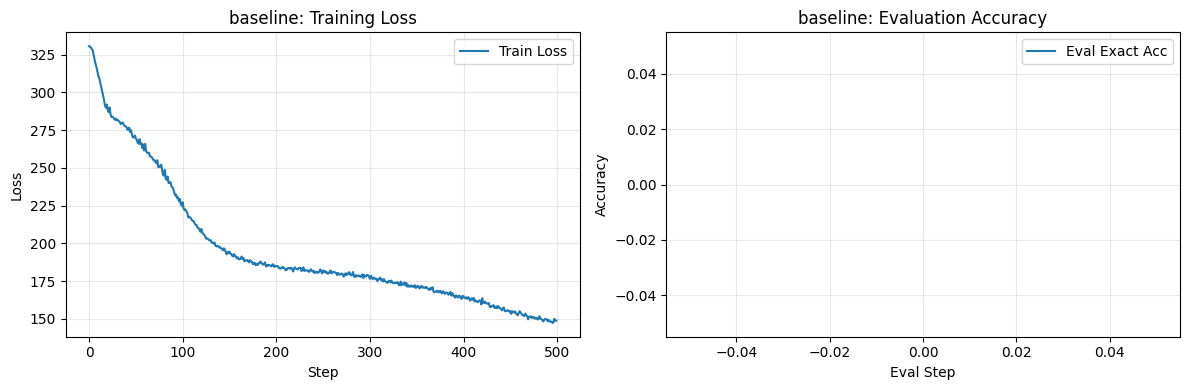


✅ Results visualization complete!


In [24]:
# ═══════════════════════════════════════════════════════════════════════════════
# Cell 29: Visualize Results
# ═══════════════════════════════════════════════════════════════════════════════

if 'RESULTS' in dir() and RESULTS:
    print("="*70)
    print("📊 Training Results Summary")
    print("="*70)

    for exp_name, result in RESULTS.items():
        print(f"\n📋 Experiment: {exp_name}")
        print(f"   Description: {EXPERIMENTS[exp_name]['description']}")
        print(f"   Final Exact Accuracy: {result['final_metrics']['eval_exact_accuracy']:.4f}")
        print(f"   Final LM Loss: {result['final_metrics']['eval_lm_loss']:.4f}")
        print(f"   Average ACT Steps: {result['final_metrics']['eval_steps']:.2f}")

        # Plot training curves if available
        if 'history' in result and result['history']:
            history = result['history']

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Loss curve
            if 'train_loss' in history:
                axes[0].plot(history['train_loss'], label='Train Loss')
            axes[0].set_xlabel('Step')
            axes[0].set_ylabel('Loss')
            axes[0].set_title(f'{exp_name}: Training Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # Accuracy curve
            if 'eval_exact_accuracy' in history:
                axes[1].plot(history['eval_exact_accuracy'], label='Eval Exact Acc')
            axes[1].set_xlabel('Eval Step')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title(f'{exp_name}: Evaluation Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    print("\n" + "="*70)
    print("✅ Results visualization complete!")
    print("="*70)
else:
    print("No results to visualize. Run the experiments first!")